In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, copy, os, shutil
from tqdm.notebook import tqdm
from IPython.display import clear_output
import pickle
import GridWorldHelpers as gwh

# create a directory to store our figures
if "figures" not in os.listdir():
    os.mkdir("figures")

# what are the variables governing our environment? also variables governing our model, and universal hparams
env_params = ["PS", "PW", "MM", "theta", "t-color", "t-in", "t-out"]
model_params = ["IM", "NC", "K", "p-shuf"]
uni_params = ["eps", "a", "g", "ASA"] # we'll just allow for both ASA, it really doesn't affect performance!
nuisance_params = ["max-iters", "seed"]
metric_params = ["num_episodes", "mean_total_reward", "mean_steps_river", "mean_path_length",
                 "mean_wallclock_time", "mean20_total_reward", "mean20_steps_river",
                 "mean20_path_length", "mean20_wallclock_time"]

# load in our logs file
logs = pd.read_csv("aggregate_logs_rev.csv")

# we're only concerned with the mean over 3 seeds
logs = logs.groupby(env_params + model_params + uni_params, dropna=False).mean().reset_index()

# color-blind friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# 3. Aggregate Results on MCAR Across $\theta$

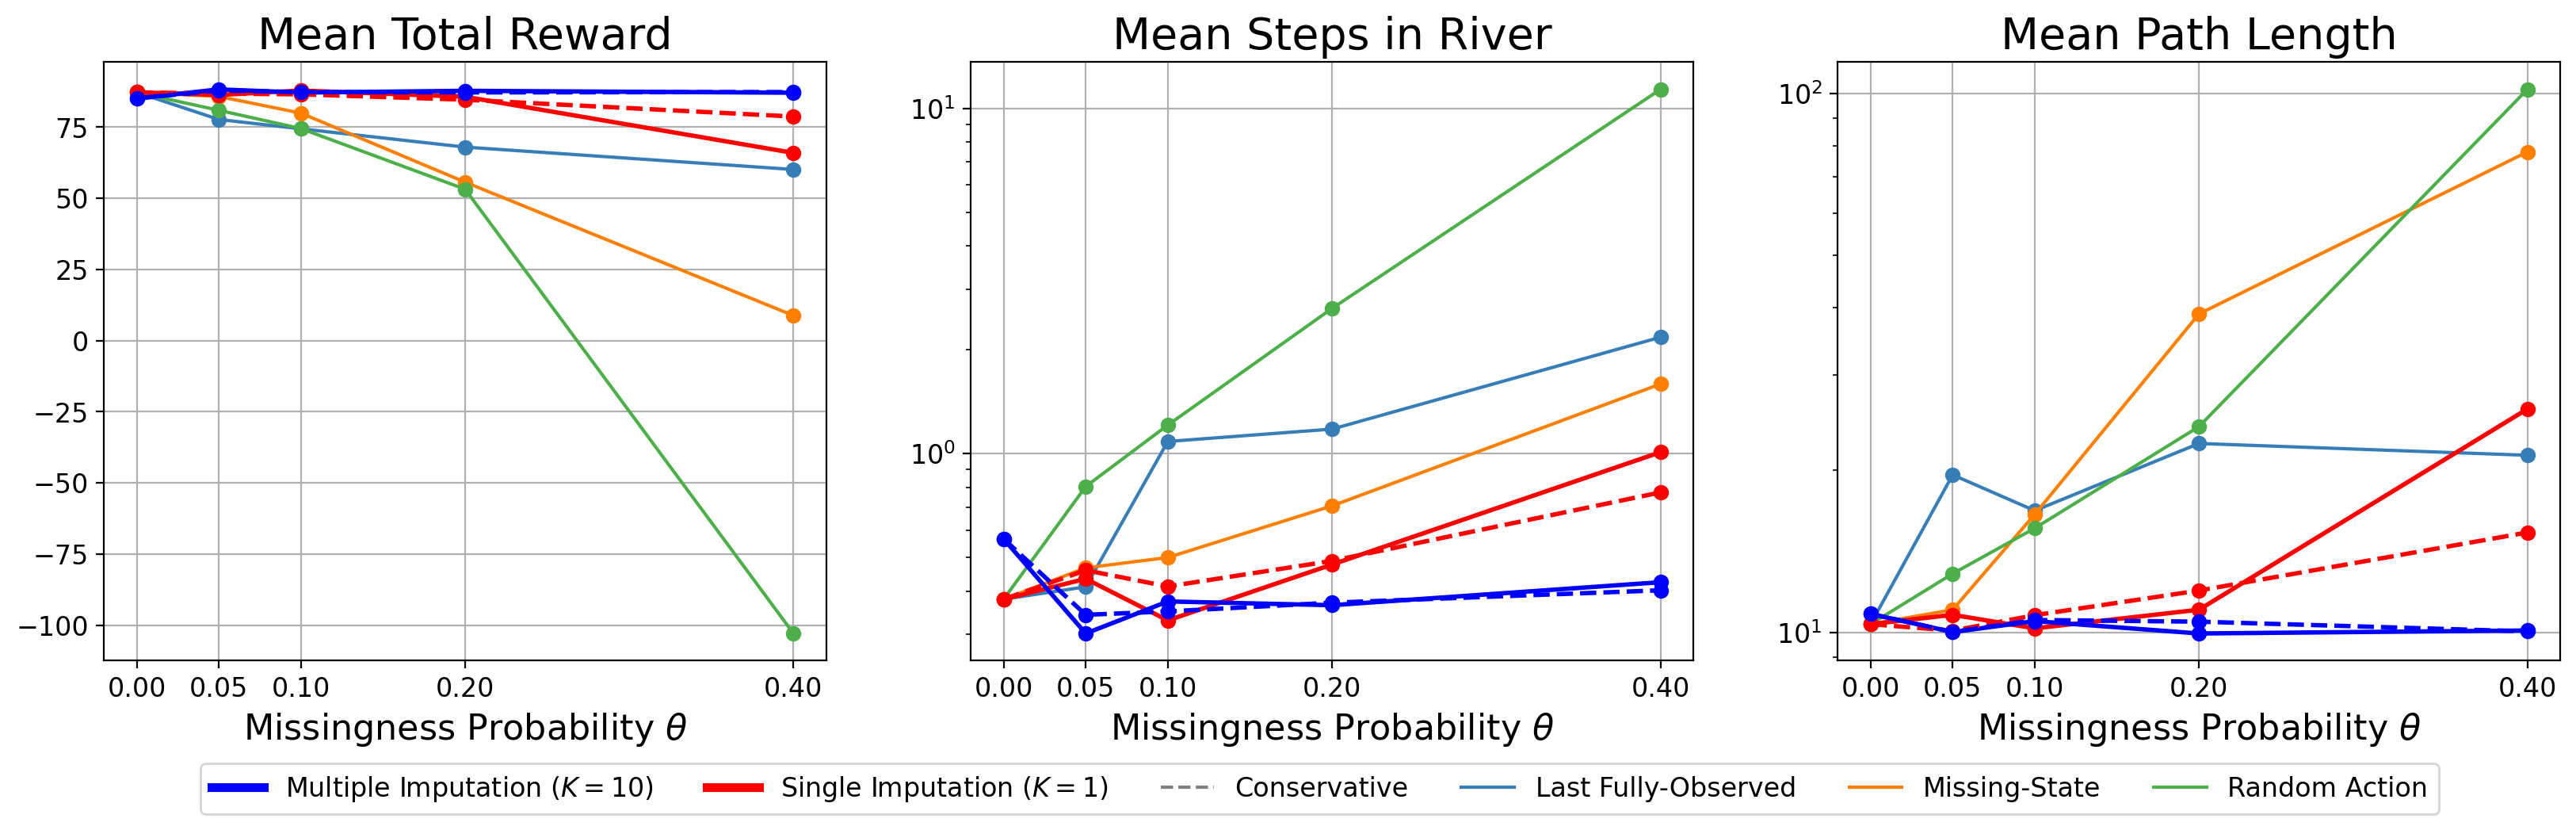

In [62]:
# 3. Lineplot of aggregate results (MCAR + max wind + switch): 1x3 grid of subplots, x-axis=theta 
# y-axis \in {mean_total_reward, mean_steps_river, mean_path_length}, each line is a model (only K=1 and K=10)
# pick best alpha, gamma, epsilon, p_shuffle, and ASA (if applicable) for each model

# create our grid of subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5))
t = "t"

# go thru each of our metrics of interest
for i, var in enumerate(["mean_total_reward", "mean_steps_river", "mean_path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Mean Total Reward", "Mean Steps in River", "Mean Path Length"][i], fontsize=20)
    ax[i].set_xlabel(f"Missingness Probability $\{t}heta$", fontsize=16)
    
    # iterate through our BASELINE models, get their values on this metric for each theta + plot them
    for j, IM in enumerate(["last-fobs", "missing-state", "random-action"]):
        
        # create our list of values for this metric
        vals = []
        
        # go thru each of our values of theta
        for theta in [0.0, 0.05, 0.1, 0.2, 0.4]:
            
            # make our relevant query + add the value to our vals
            val = logs.query(f"PS == 0.1 and PW == 0.1 and MM == 'MCAR' and theta == {theta}")\
            .sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)\
            .groupby(model_params[:-1], dropna=False).first().reset_index().query("K != 5")\
            .query(f"IM == '{IM}'")[var].values[0]
            vals.append(val)
        
        # make our plot for this IM baseline model
        if i == 0:
            ax[i].plot([0.0, 0.05, 0.1, 0.2, 0.4], vals, marker="o", color=colors[j])
        else:
            ax[i].semilogy([0.0, 0.05, 0.1, 0.2, 0.4], vals, marker="o", color=colors[j])
        
    # iterate thru MI models, get their values on this metric for each theta + plot them
    for j, IM in enumerate(["joint", "joint-conservative"]):
        for k, K in enumerate([1, 10]):
        
            # create our list of values for this metric
            vals = []

            # go thru each of our values of theta
            for theta in [0.0, 0.05, 0.1, 0.2, 0.4]:

                # make our relevant query + add the value to our vals
                val = logs.query(f"PS == 0.1 and PW == 0.1 and MM == 'MCAR' and theta == {theta}")\
                .sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)\
                .groupby(model_params[:-1], dropna=False).first().reset_index().query(f"K == {K}")\
                .query(f"IM == '{IM}'")[var].values[0]
                vals.append(val)

            # make our plot for this IM baseline model
            color = "blue" if K == 10 else "red"
            linestyle = "--" if "conservative" in IM else None
            if i == 0:
                ax[i].plot([0.0, 0.05, 0.1, 0.2, 0.4], vals, marker="o", 
                           color=color, linestyle=linestyle, linewidth=2)
            else:
                ax[i].semilogy([0.0, 0.05, 0.1, 0.2, 0.4], vals, marker="o", 
                               color=color, linestyle=linestyle, linewidth=2)
        
    # beautify a little bit
    ax[i].set_xticks([0.0, 0.05, 0.1, 0.2, 0.4])
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Multiple Imputation ($K=10$)")
        ax[i].plot([np.nan], [np.nan], color="red", linewidth=4, label="Single Imputation ($K=1$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", label="Conservative")
        ax[i].plot([np.nan], [np.nan], color=colors[0], label="Last Fully-Observed")
        ax[i].plot([np.nan], [np.nan], color=colors[1], label="Missing-State")
        ax[i].plot([np.nan], [np.nan], color=colors[2], label="Random Action")
        ax[i].legend(ncol=6, fontsize=12, bbox_to_anchor=(+0.85, -0.15))
        
# save our figure
plt.savefig("figures/MCAR-hardest_perf-over-theta.png", facecolor="white", bbox_inches="tight")
plt.show()

# 4. Performance Over Time - MCAR + $\theta = 0.4$

In [152]:
# 4. learning plots over time (MCAR + max_wind + max_switch at theta=0.4): 1x3
# x-axis = timestep -- let's do stepplot to make use of per-episode metrics. 
# y-axis: {reward, river_steps, path_length}, 3 baselines + K={1, 10} x {joint, joint-cons} x {best shuffle}

# make our relevant query
q = logs.query("PS == 0.1 and PW == 0.1 and MM == 'MCAR' and theta == 0.4")\
.sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)

q.groupby(model_params[:-1], dropna=False).first().reset_index().query("K != 5")

,IM,NC,K,p-shuf,eps,a,g,ASA,max-iters,seed,num_episodes,mean_total_reward,mean_steps_river,mean_path_length,mean_wallclock_time,mean20_total_reward,mean20_steps_river,mean20_path_length,mean20_wallclock_time
0,joint,1.0,1.0,0.1,0.05,0.1,1.0,False,50000.0,1.0,2180.333333,65.943682,1.010217,25.964367,0.235222,76.516667,0.516667,19.833333,0.182168
2,joint,1.0,10.0,0.0,0.00,0.1,1.0,False,50000.0,1.0,4997.000000,87.102255,0.424475,10.077467,0.889789,88.883333,0.316667,9.266667,0.804486
3,joint-conservative,1.0,1.0,0.0,0.05,0.1,1.0,False,50000.0,1.0,3270.666667,78.726432,0.772660,15.319628,0.136264,84.616667,0.500000,11.883333,0.106253
5,joint-conservative,1.0,10.0,0.0,0.00,0.1,1.0,True,50000.0,1.0,4995.333333,87.342624,0.402167,10.037875,0.989470,89.666667,0.266667,8.933333,0.874059
6,last-fobs,NaN,NaN,NaN,0.05,0.1,1.0,True,50000.0,1.0,2362.666667,60.121635,2.174607,21.306900,0.179446,63.716667,2.366667,15.983333,0.135352
7,missing-state,NaN,NaN,NaN,0.00,0.1,1.0,False,50000.0,1.0,690.333333,8.791504,1.591697,77.883228,1.051322,35.983333,0.550000,60.066667,0.819971
8,random-action,NaN,NaN,NaN,0.00,0.1,1.0,False,50000.0,1.0,497.333333,-102.948647,11.356518,101.739986,0.052874,-55.500000,8.633333,78.800000,0.038333


In [153]:
j1_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_IM=joint_NC=1_K=1_p-shuf=0.1_max-iters=50000_eps=0.05_a=0.1_g=1.0"
j1 = pd.read_csv(f"results/{j1_fname}/seed=0.csv")

j10_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_IM=joint_NC=1_K=10_p-shuf=0.0_max-iters=50000_eps=0.0_a=0.1_g=1.0"
j10 = pd.read_csv(f"results/{j10_fname}/seed=0.csv")

jc1_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_IM=joint-conservative_NC=1_K=1_p-shuf=0.0_max-iters=50000_eps=0.05_a=0.1_g=1.0"
jc1 = pd.read_csv(f"results/{jc1_fname}/seed=0.csv")

jc10_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=T_theta=0.4_IM=joint-conservative_NC=1_K=10_p-shuf=0.0_max-iters=50000_eps=0.0_a=0.1_g=1.0"
jc10 = pd.read_csv(f"results/{jc10_fname}/seed=0.csv")

lf_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=T_theta=0.4_IM=last-fobs_max-iters=50000_eps=0.05_a=0.1_g=1.0"
lf = pd.read_csv(f"results/{lf_fname}/seed=0.csv")

ms_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_IM=missing-state_max-iters=50000_eps=0.0_a=0.1_g=1.0"
ms = pd.read_csv(f"results/{ms_fname}/seed=0.csv")

ra_fname = "PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_IM=random-action_max-iters=50000_eps=0.0_a=0.1_g=1.0"
ra = pd.read_csv(f"results/{ra_fname}/seed=0.csv")

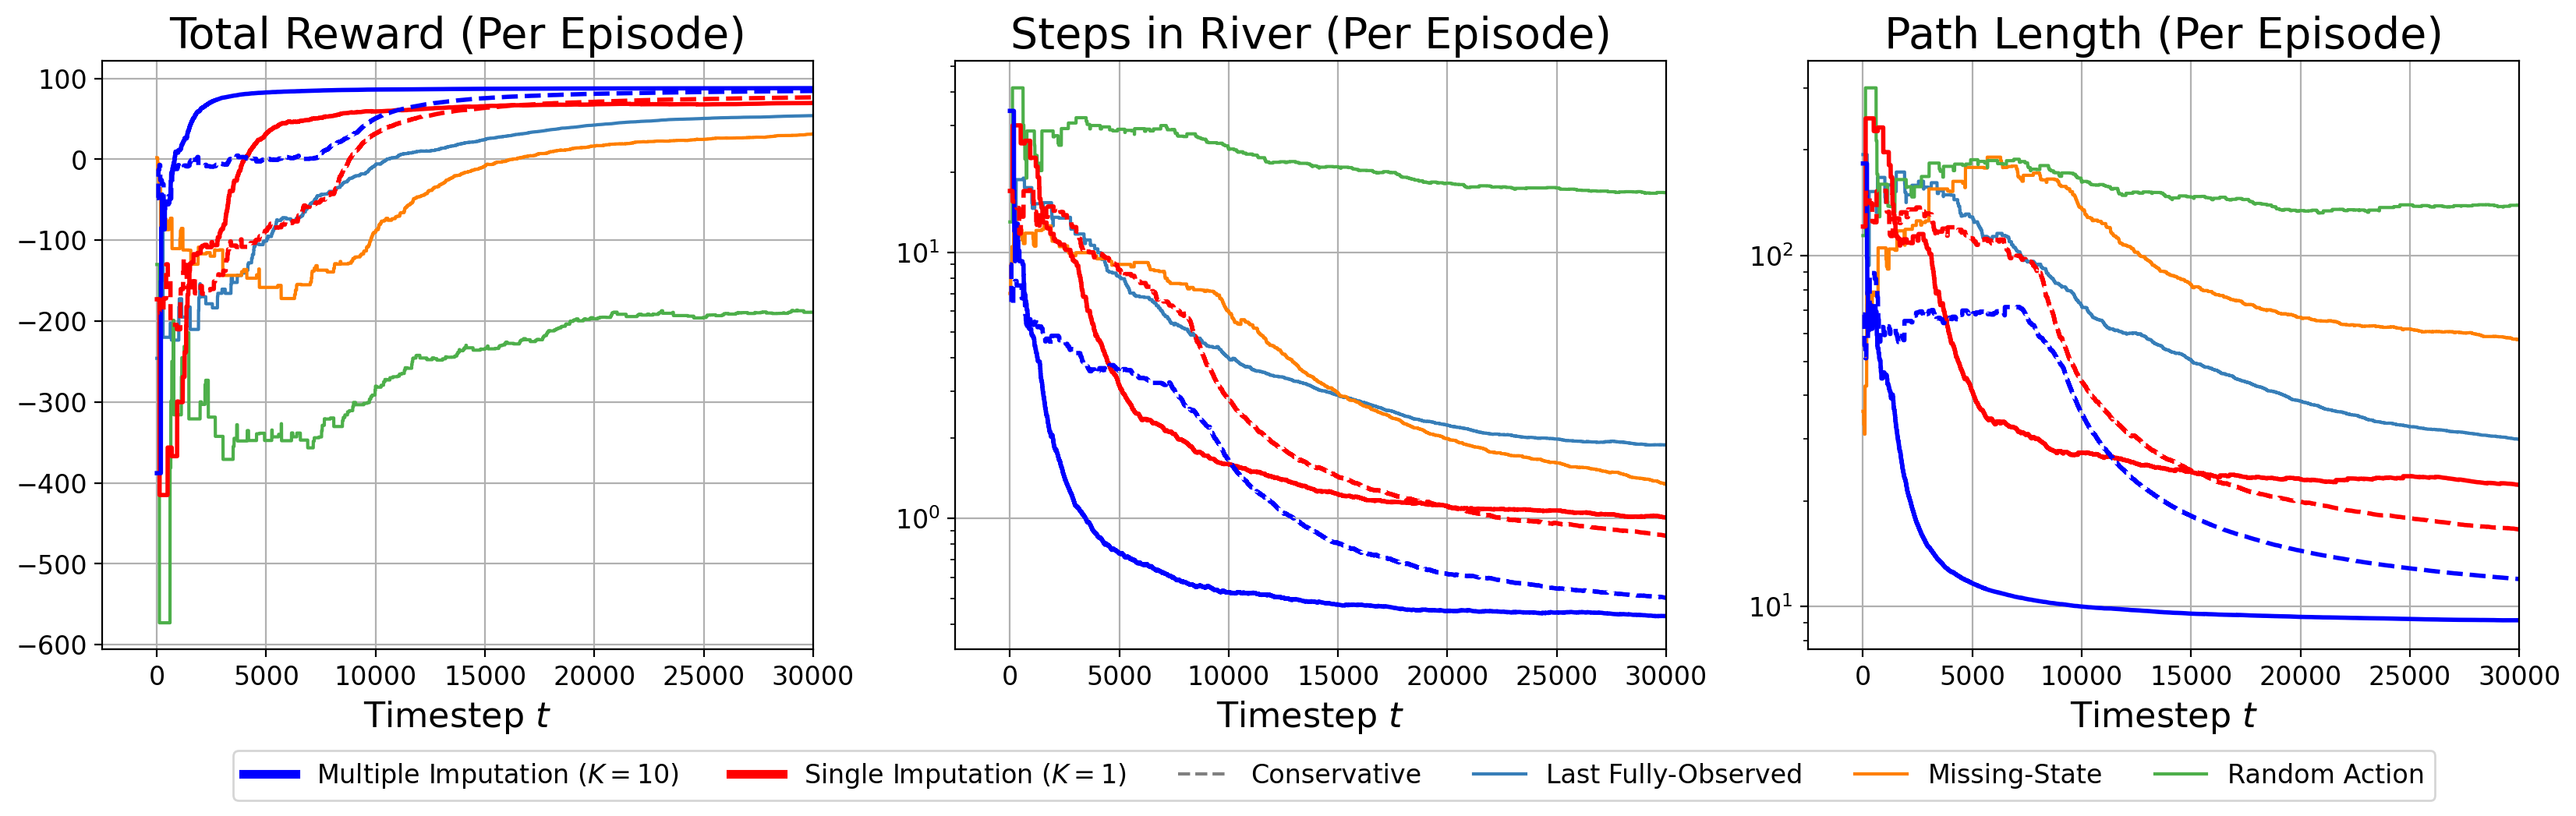

In [154]:
# create our subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5), sharex=True)

# cutoff for iterations 
CUTOFF = 30000

# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Total Reward (Per Episode)", "Steps in River (Per Episode)", "Path Length (Per Episode)"][i], fontsize=20)
    ax[i].set_xlabel("Timestep $t$", fontsize=16)
    
    #### BASELINES
    
    # plot last-fobs performance
    if i == 0:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].plot(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].plot(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].plot(ra_vals, color=colors[2])
        
    else:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].semilogy(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].semilogy(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].semilogy(ra_vals, color=colors[2])
    
    #### OUR METHODS
    
    if i == 0:
    
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].plot(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].plot(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].plot(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].plot(jc10_vals, color="blue", linestyle="--", linewidth=2)
        
    else:
        
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].semilogy(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].semilogy(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].semilogy(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].semilogy(jc10_vals, color="blue", linestyle="--", linewidth=2)
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].set_xlim(right=CUTOFF)
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Multiple Imputation ($K=10$)")
        ax[i].plot([np.nan], [np.nan], color="red", linewidth=4, label="Single Imputation ($K=1$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", label="Conservative")
        ax[i].plot([np.nan], [np.nan], color=colors[0], label="Last Fully-Observed")
        ax[i].plot([np.nan], [np.nan], color=colors[1], label="Missing-State")
        ax[i].plot([np.nan], [np.nan], color=colors[2], label="Random Action")
        ax[i].legend(ncol=6, fontsize=12, bbox_to_anchor=(+0.9, -0.15))
        
# save the figure
plt.savefig("figures/MCAR-hardest+most-missingness_perf-over-time.png", facecolor="white", bbox_inches="tight")
plt.show()

# Performance Over Time - MCOLOR + MAX MISSING

In [155]:
# 4. learning plots over time (MCOLOR + max_wind + max_switch at t-color=0.1): 1x3
# x-axis = timestep -- let's do stepplot to make use of per-episode metrics. 
# y-axis: {reward, river_steps, path_length}, 3 baselines + K={1, 10} x {joint, joint-cons} x {best shuffle}

# make our relevant query
q = logs.query("PS == 0.1 and PW == 0.1 and MM == 'Mcolor' and `t-color` == 0.1")\
.sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)
q.groupby(model_params[:-1], dropna=False).first().reset_index().query("K != 5")

,IM,NC,K,p-shuf,eps,a,g,ASA,max-iters,seed,num_episodes,mean_total_reward,mean_steps_river,mean_path_length,mean_wallclock_time,mean20_total_reward,mean20_steps_river,mean20_path_length,mean20_wallclock_time
0,joint,1.0,1.0,0.0,0.00,0.1,1.0,True,50000.0,1.0,4755.333333,86.536735,0.438361,10.518016,0.098465,87.916667,0.416667,9.333333,0.087578
2,joint,1.0,10.0,0.1,0.00,0.1,1.0,False,50000.0,1.0,4974.666667,87.817221,0.343524,10.091064,0.844480,89.250000,0.300000,9.050000,0.764672
3,joint-conservative,1.0,1.0,0.1,0.00,0.1,1.0,False,50000.0,1.0,4721.333333,86.302598,0.452977,10.620612,0.088364,89.150000,0.283333,9.300000,0.076632
5,joint-conservative,1.0,10.0,0.0,0.00,0.1,1.0,True,50000.0,1.0,5093.333333,88.196720,0.331153,9.822906,0.930728,89.666667,0.283333,8.783333,0.838999
6,last-fobs,NaN,NaN,NaN,0.00,0.1,0.5,False,50000.0,1.0,2640.333333,74.912850,0.793303,18.947419,0.140200,79.050000,0.933333,13.550000,0.100875
7,missing-state,NaN,NaN,NaN,0.05,0.1,1.0,True,50000.0,1.0,3211.333333,78.975658,0.694869,15.770521,0.220798,83.033333,0.500000,13.466667,0.190054
8,random-action,NaN,NaN,NaN,0.05,0.1,1.0,False,50000.0,1.0,3001.333333,68.426554,1.759052,16.741977,0.065696,71.300000,1.600000,15.300000,0.061115


In [156]:
# create a common header + abbreviations
head = "PS=0.1_PW=0.1_MM=Mcolor"
MI = "max-iters=50000"
ts = "t-color=0.1"

j1_fname = f"{head}_ASA=T_{ts}_IM=joint_NC=1_K=1_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
j1 = pd.read_csv(f"results/{j1_fname}/seed=0.csv")

j10_fname = f"{head}_ASA=F_{ts}_IM=joint_NC=1_K=10_p-shuf=0.1_{MI}_eps=0.0_a=0.1_g=1.0"
j10 = pd.read_csv(f"results/{j10_fname}/seed=0.csv")

jc1_fname = f"{head}_ASA=F_{ts}_IM=joint-conservative_NC=1_K=1_p-shuf=0.1_{MI}_eps=0.0_a=0.1_g=1.0"
jc1 = pd.read_csv(f"results/{jc1_fname}/seed=0.csv")

jc10_fname = f"{head}_ASA=T_{ts}_IM=joint-conservative_NC=1_K=10_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
jc10 = pd.read_csv(f"results/{jc10_fname}/seed=0.csv")

lf_fname = f"{head}_ASA=F_{ts}_IM=last-fobs_{MI}_eps=0.0_a=0.1_g=1.0"
lf = pd.read_csv(f"results/{lf_fname}/seed=0.csv")

ms_fname = f"{head}_ASA=T_{ts}_IM=missing-state_{MI}_eps=0.05_a=0.1_g=0.5"
ms = pd.read_csv(f"results/{ms_fname}/seed=0.csv")

ra_fname = f"{head}_ASA=F_{ts}_IM=random-action_{MI}_eps=0.05_a=0.1_g=1.0"
ra = pd.read_csv(f"results/{ra_fname}/seed=0.csv")

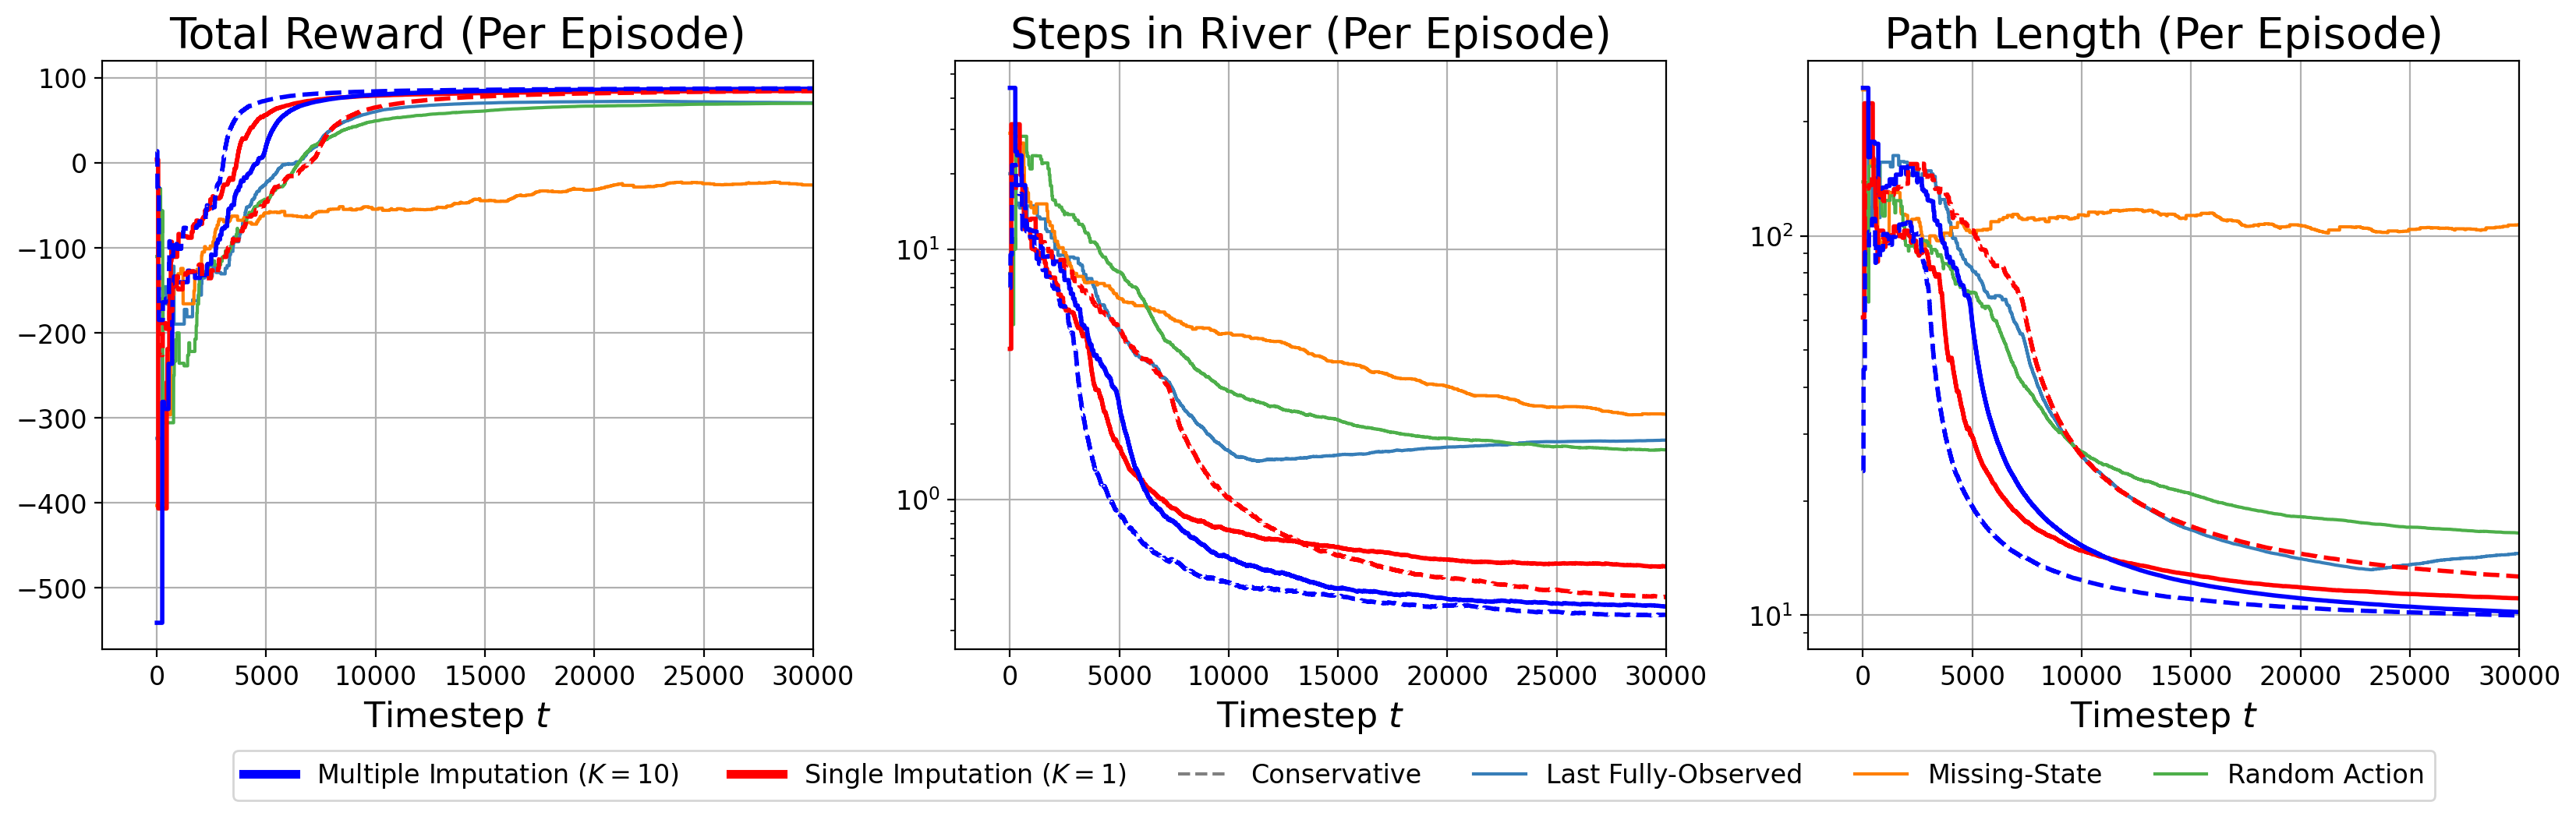

In [158]:
# create our subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5), sharex=True)

# cutoff for iterations 
CUTOFF = 30000

# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Total Reward (Per Episode)", "Steps in River (Per Episode)", "Path Length (Per Episode)"][i], fontsize=20)
    ax[i].set_xlabel("Timestep $t$", fontsize=16)
    
    #### BASELINES
    
    # plot last-fobs performance
    if i == 0:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].plot(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].plot(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].plot(ra_vals, color=colors[2])
        
    else:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].semilogy(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].semilogy(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].semilogy(ra_vals, color=colors[2])
    
    #### OUR METHODS
    
    if i == 0:
    
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].plot(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].plot(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].plot(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].plot(jc10_vals, color="blue", linestyle="--", linewidth=2)
        
    else:
        
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].semilogy(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].semilogy(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].semilogy(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].semilogy(jc10_vals, color="blue", linestyle="--", linewidth=2)
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Multiple Imputation ($K=10$)")
        ax[i].plot([np.nan], [np.nan], color="red", linewidth=4, label="Single Imputation ($K=1$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", label="Conservative")
        ax[i].plot([np.nan], [np.nan], color=colors[0], label="Last Fully-Observed")
        ax[i].plot([np.nan], [np.nan], color=colors[1], label="Missing-State")
        ax[i].plot([np.nan], [np.nan], color=colors[2], label="Random Action")
        ax[i].legend(ncol=6, fontsize=12, bbox_to_anchor=(+0.9, -0.15))
        ax[i].set_xlim(right=CUTOFF)
        
# save the figure
plt.savefig("figures/Mcolor-hardest+most-missingness_perf-over-time.png", facecolor="white", bbox_inches="tight")
plt.show()

# MCOLOR - Hardest Settings. Never Missing Color.

In [164]:
# 4. learning plots over time (MCOLOR + max_wind + max_switch at t-color=0.1): 1x3
# x-axis = timestep -- let's do stepplot to make use of per-episode metrics. 
# y-axis: {reward, river_steps, path_length}, 3 baselines + K={1, 10} x {joint, joint-cons} x {best shuffle}

# make our relevant query
q = logs.query("PS == 0.1 and PW == 0.1 and MM == 'Mcolor' and `t-color` == 0.0")\
.sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)
q.groupby(model_params[:-1], dropna=False).first().reset_index().query("K != 5")

,IM,NC,K,p-shuf,eps,a,g,ASA,max-iters,seed,num_episodes,mean_total_reward,mean_steps_river,mean_path_length,mean_wallclock_time,mean20_total_reward,mean20_steps_river,mean20_path_length,mean20_wallclock_time
0,joint,1.0,1.0,0.1,0.0,0.1,1.0,True,50000.0,1.0,4934.666667,87.123855,0.414155,10.148752,0.092628,87.833333,0.350000,10.016667,0.091590
2,joint,1.0,10.0,0.0,0.0,0.1,1.0,False,50000.0,1.0,4813.000000,86.808837,0.420162,10.409707,0.865374,87.816667,0.416667,9.433333,0.779792
3,joint-conservative,1.0,1.0,0.0,0.0,0.1,1.0,False,50000.0,1.0,4641.666667,87.249983,0.326129,10.814859,0.088915,86.766667,0.483333,9.883333,0.081630
5,joint-conservative,1.0,10.0,0.0,0.0,0.1,1.0,False,50000.0,1.0,5062.000000,88.244357,0.318993,9.884705,0.815368,90.183333,0.200000,9.016667,0.759518
6,last-fobs,NaN,NaN,NaN,0.0,0.1,0.5,False,50000.0,1.0,2439.666667,75.541069,0.550989,20.500033,0.151142,76.966667,0.700000,17.733333,0.132027
7,missing-state,NaN,NaN,NaN,0.0,0.1,1.0,False,50000.0,1.0,3431.000000,82.091455,0.468391,14.693029,0.193114,84.733333,0.233333,14.166667,0.187299
8,random-action,NaN,NaN,NaN,0.0,0.1,1.0,True,50000.0,1.0,3954.000000,79.470500,0.987293,12.643860,0.072821,80.166667,0.983333,11.983333,0.069047


In [165]:
# create a common header + abbreviations
head = "PS=0.1_PW=0.1_MM=Mcolor"
MI = "max-iters=50000"
ts = "t-color=0.0"

j1_fname = f"{head}_ASA=T_{ts}_IM=joint_NC=1_K=1_p-shuf=0.1_{MI}_eps=0.0_a=0.1_g=1.0"
j1 = pd.read_csv(f"results/{j1_fname}/seed=0.csv")

j10_fname = f"{head}_ASA=F_{ts}_IM=joint_NC=1_K=10_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
j10 = pd.read_csv(f"results/{j10_fname}/seed=0.csv")

jc1_fname = f"{head}_ASA=F_{ts}_IM=joint-conservative_NC=1_K=1_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
jc1 = pd.read_csv(f"results/{jc1_fname}/seed=0.csv")

jc10_fname = f"{head}_ASA=T_{ts}_IM=joint-conservative_NC=1_K=10_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
jc10 = pd.read_csv(f"results/{jc10_fname}/seed=0.csv")

lf_fname = f"{head}_ASA=F_{ts}_IM=last-fobs_{MI}_eps=0.0_a=0.1_g=0.5"
lf = pd.read_csv(f"results/{lf_fname}/seed=0.csv")

ms_fname = f"{head}_ASA=T_{ts}_IM=missing-state_{MI}_eps=0.0_a=0.1_g=1.0"
ms = pd.read_csv(f"results/{ms_fname}/seed=0.csv")

ra_fname = f"{head}_ASA=F_{ts}_IM=random-action_{MI}_eps=0.0_a=0.1_g=1.0"
ra = pd.read_csv(f"results/{ra_fname}/seed=0.csv")

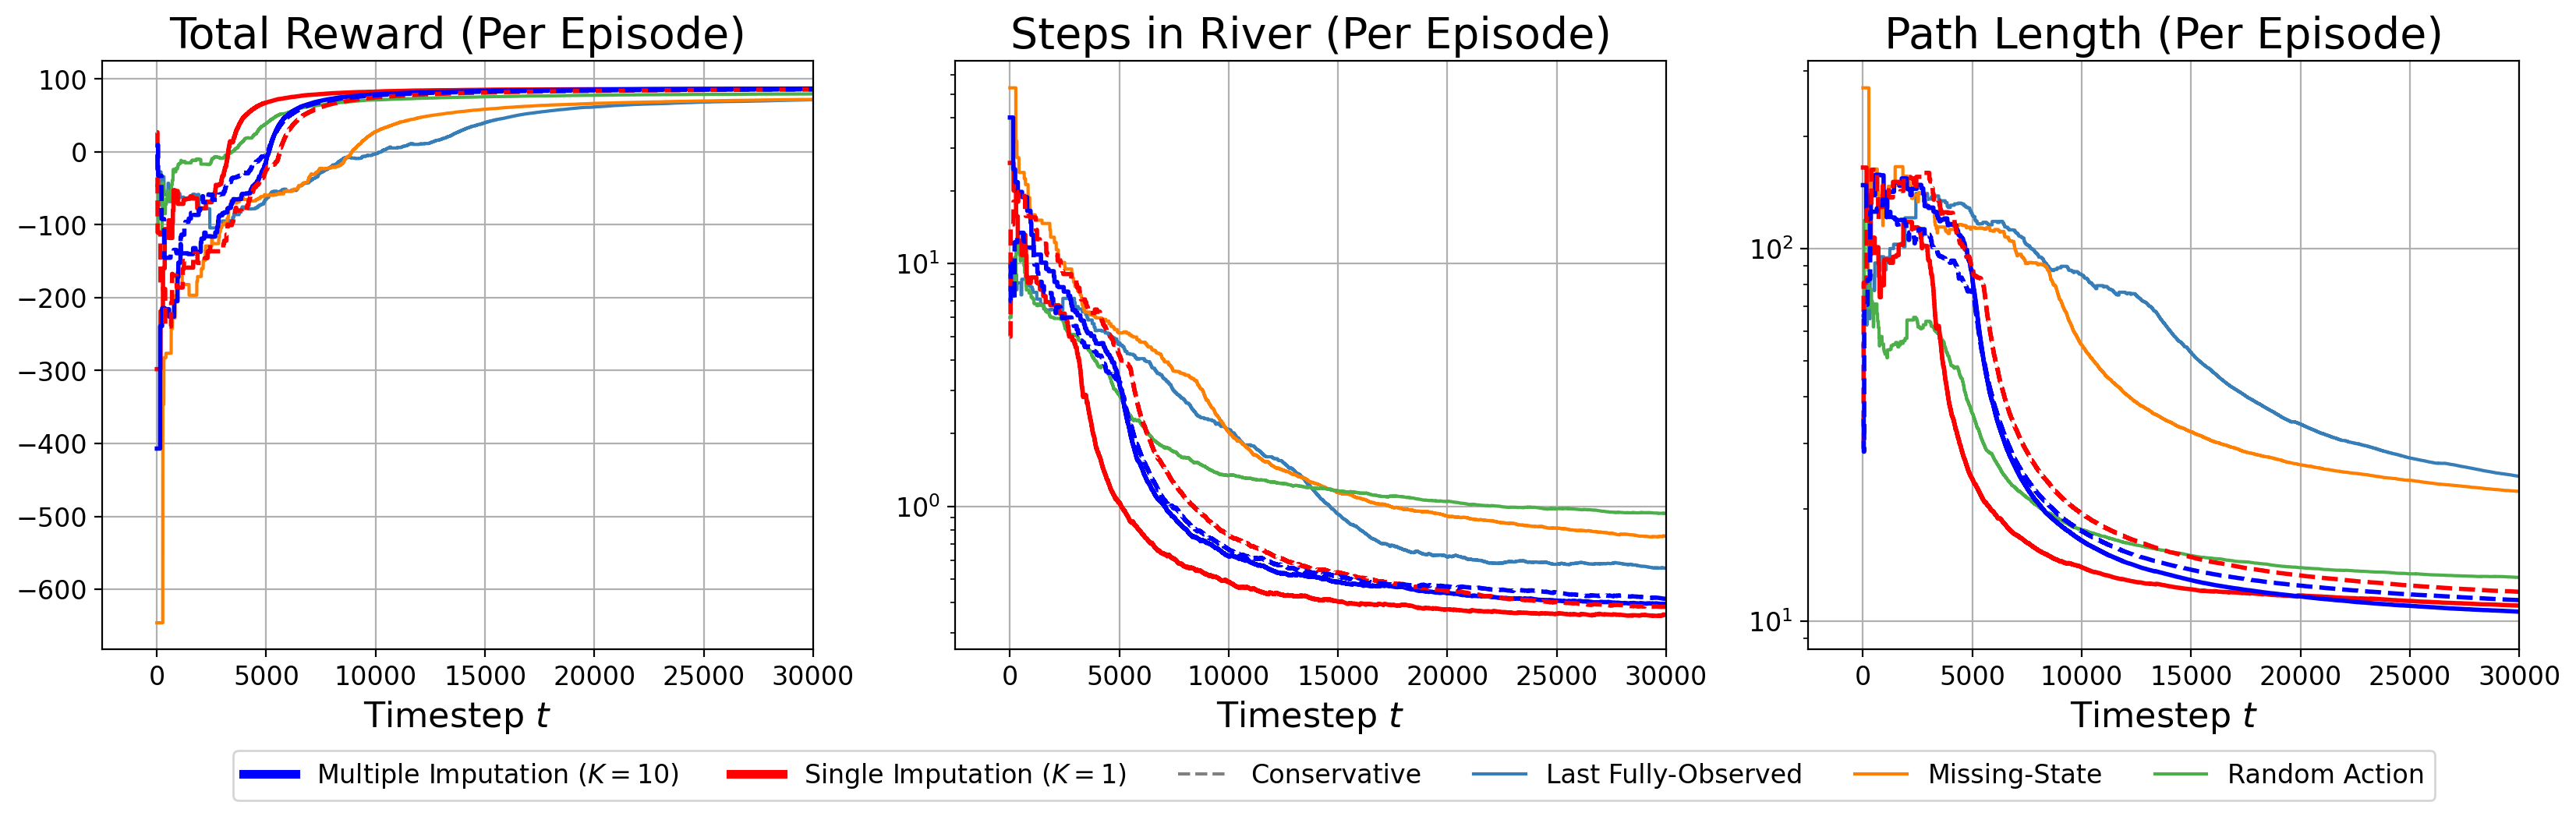

In [166]:
# create our subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5), sharex=True)

# cutoff for iterations 
CUTOFF = 30000

# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Total Reward (Per Episode)", "Steps in River (Per Episode)", "Path Length (Per Episode)"][i], fontsize=20)
    ax[i].set_xlabel("Timestep $t$", fontsize=16)
    
    #### BASELINES
    
    # plot last-fobs performance
    if i == 0:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].plot(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].plot(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].plot(ra_vals, color=colors[2])
        
    else:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].semilogy(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].semilogy(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].semilogy(ra_vals, color=colors[2])
    
    #### OUR METHODS
    
    if i == 0:
    
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].plot(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].plot(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].plot(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].plot(jc10_vals, color="blue", linestyle="--", linewidth=2)
        
    else:
        
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].semilogy(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].semilogy(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].semilogy(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].semilogy(jc10_vals, color="blue", linestyle="--", linewidth=2)
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Multiple Imputation ($K=10$)")
        ax[i].plot([np.nan], [np.nan], color="red", linewidth=4, label="Single Imputation ($K=1$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", label="Conservative")
        ax[i].plot([np.nan], [np.nan], color=colors[0], label="Last Fully-Observed")
        ax[i].plot([np.nan], [np.nan], color=colors[1], label="Missing-State")
        ax[i].plot([np.nan], [np.nan], color=colors[2], label="Random Action")
        ax[i].legend(ncol=6, fontsize=12, bbox_to_anchor=(+0.9, -0.15))
        ax[i].set_xlim(right=CUTOFF)
        
# save the figure
plt.savefig("figures/Mcolor-hardest+never-missing-color_perf-over-time.png", facecolor="white", bbox_inches="tight")
plt.show()

# MFOG - Hardest Settings, Complete GPS Jamming

In [167]:
# 4. learning plots over time (MCOLOR + max_wind + max_switch at t-color=0.1): 1x3
# x-axis = timestep -- let's do stepplot to make use of per-episode metrics. 
# y-axis: {reward, river_steps, path_length}, 3 baselines + K={1, 10} x {joint, joint-cons} x {best shuffle}

# make our relevant query
q = logs.query("PS == 0.1 and PW == 0.1 and MM == 'Mfog' and `t-in` == 0.5")\
.sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)
q.groupby(model_params[:-1], dropna=False).first().reset_index().query("K != 5")

,IM,NC,K,p-shuf,eps,a,g,ASA,max-iters,seed,num_episodes,mean_total_reward,mean_steps_river,mean_path_length,mean_wallclock_time,mean20_total_reward,mean20_steps_river,mean20_path_length,mean20_wallclock_time
0,joint,1.0,1.0,0.1,0.00,0.1,1.0,False,50000.0,1.0,4621.000000,86.485887,0.402958,10.887489,0.088002,86.116667,0.516667,10.233333,0.082879
2,joint,1.0,10.0,0.0,0.00,0.1,1.0,False,50000.0,1.0,4967.666667,87.887273,0.337544,10.074828,0.833326,88.583333,0.300000,9.716667,0.783798
3,joint-conservative,1.0,1.0,0.1,0.05,0.1,1.0,False,50000.0,1.0,4776.333333,86.177506,0.477048,10.529062,0.078710,88.383333,0.350000,9.466667,0.071059
5,joint-conservative,1.0,10.0,0.1,0.00,0.1,1.0,False,50000.0,1.0,4879.333333,87.759731,0.328153,10.286896,0.831514,89.583333,0.216667,9.466667,0.756158
6,last-fobs,NaN,NaN,NaN,0.00,0.1,1.0,False,50000.0,1.0,4674.000000,87.061111,0.355610,10.738401,0.092667,88.400000,0.283333,10.050000,0.086455
7,missing-state,NaN,NaN,NaN,0.05,0.1,1.0,False,50000.0,1.0,4643.333333,86.147963,0.448839,10.812482,0.130063,86.150000,0.550000,9.900000,0.119439
8,random-action,NaN,NaN,NaN,0.00,0.1,1.0,False,50000.0,1.0,4425.333333,86.224003,0.382483,11.333653,0.092932,90.216667,0.100000,9.883333,0.083186


In [169]:
# create a common header + abbreviations
head = "PS=0.1_PW=0.1_MM=Mfog"
MI = "max-iters=50000"
ts = "t-in=0.5_t-out=0.0"

j1_fname = f"{head}_ASA=T_{ts}_IM=joint_NC=1_K=1_p-shuf=0.1_{MI}_eps=0.0_a=0.1_g=1.0"
j1 = pd.read_csv(f"results/{j1_fname}/seed=0.csv")

j10_fname = f"{head}_ASA=F_{ts}_IM=joint_NC=1_K=10_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
j10 = pd.read_csv(f"results/{j10_fname}/seed=0.csv")

jc1_fname = f"{head}_ASA=F_{ts}_IM=joint-conservative_NC=1_K=1_p-shuf=0.1_{MI}_eps=0.05_a=0.1_g=1.0"
jc1 = pd.read_csv(f"results/{jc1_fname}/seed=0.csv")

jc10_fname = f"{head}_ASA=T_{ts}_IM=joint-conservative_NC=1_K=10_p-shuf=0.1_{MI}_eps=0.0_a=0.1_g=1.0"
jc10 = pd.read_csv(f"results/{jc10_fname}/seed=0.csv")

lf_fname = f"{head}_ASA=F_{ts}_IM=last-fobs_{MI}_eps=0.0_a=0.1_g=1.0"
lf = pd.read_csv(f"results/{lf_fname}/seed=0.csv")

ms_fname = f"{head}_ASA=T_{ts}_IM=missing-state_{MI}_eps=0.05_a=0.1_g=0.5"
ms = pd.read_csv(f"results/{ms_fname}/seed=0.csv")

ra_fname = f"{head}_ASA=F_{ts}_IM=random-action_{MI}_eps=0.0_a=0.1_g=1.0"
ra = pd.read_csv(f"results/{ra_fname}/seed=0.csv")

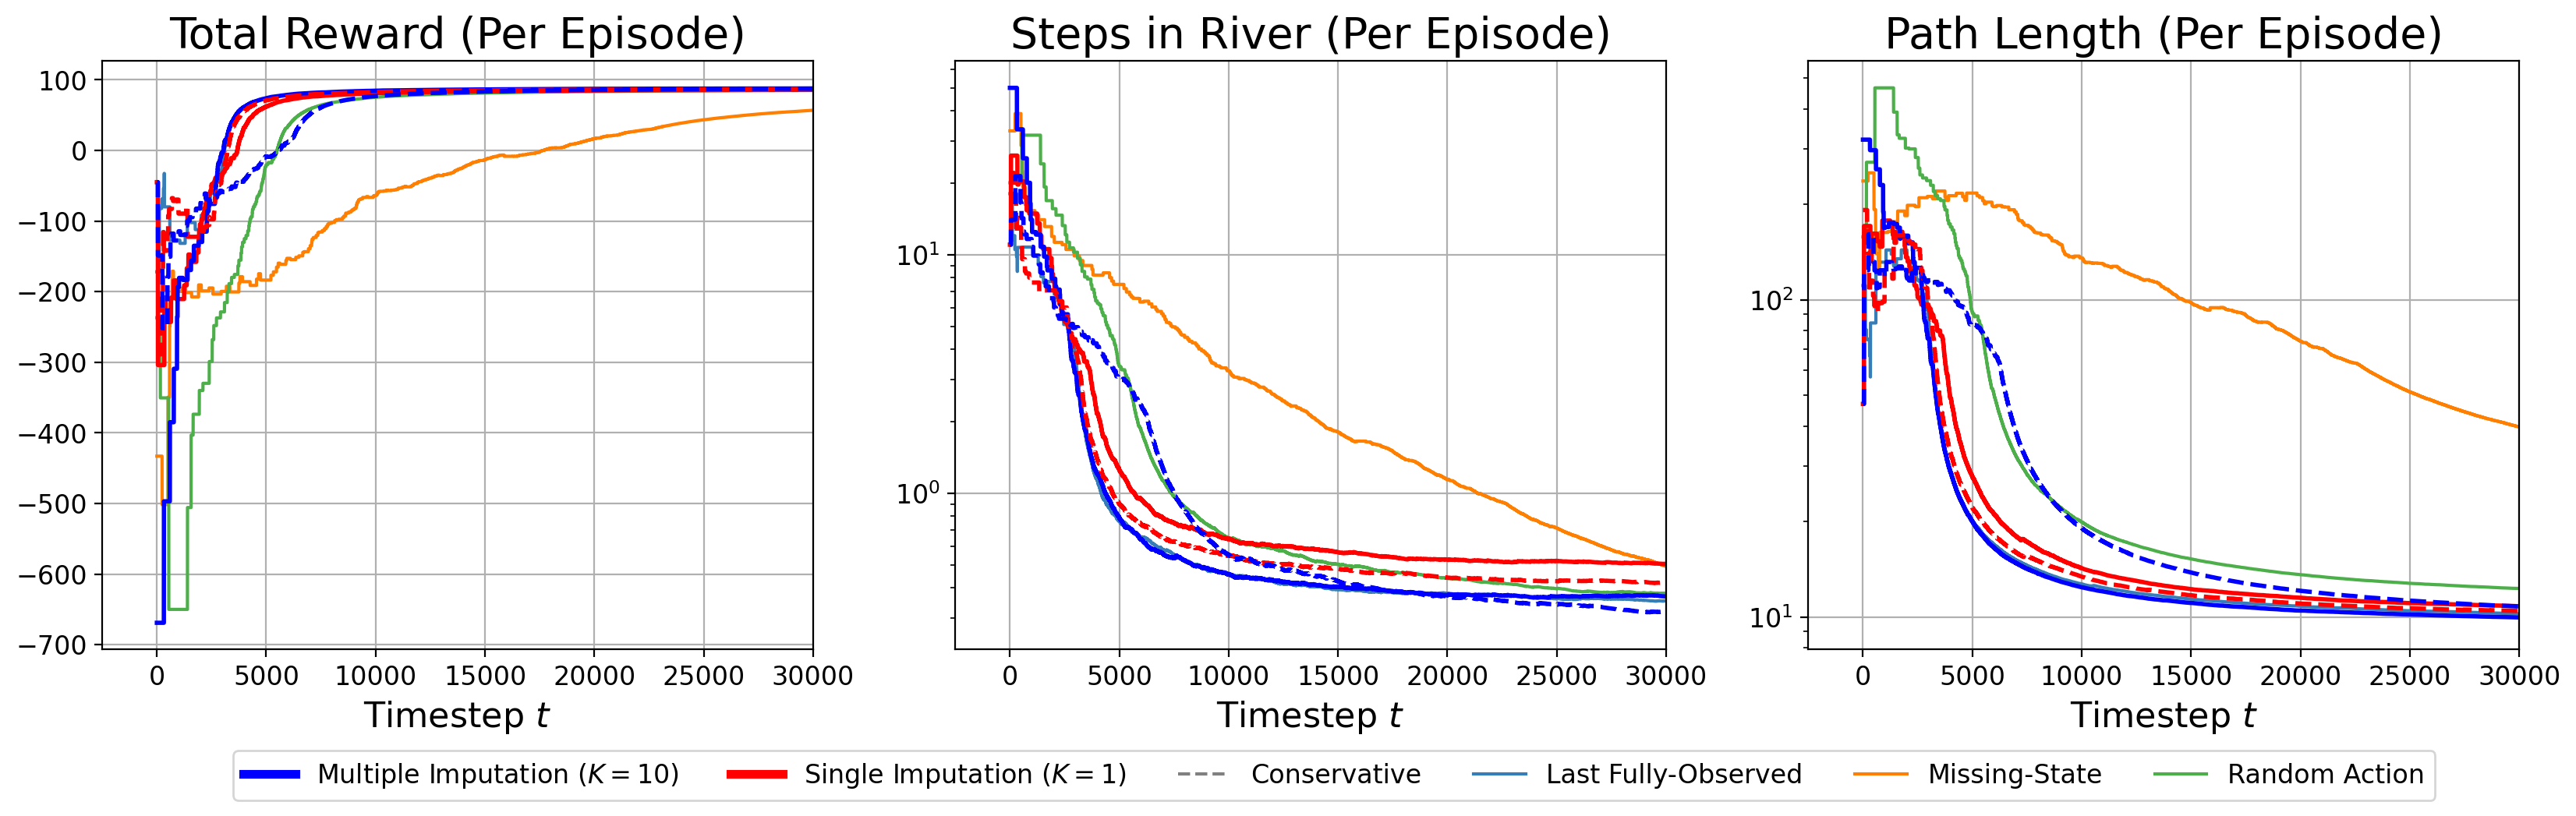

In [170]:
# create our subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5), sharex=True)

# cutoff for iterations 
CUTOFF = 30000

# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Total Reward (Per Episode)", "Steps in River (Per Episode)", "Path Length (Per Episode)"][i], fontsize=20)
    ax[i].set_xlabel("Timestep $t$", fontsize=16)
    
    #### BASELINES
    
    # plot last-fobs performance
    if i == 0:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].plot(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].plot(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].plot(ra_vals, color=colors[2])
        
    else:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].semilogy(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].semilogy(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].semilogy(ra_vals, color=colors[2])
    
    #### OUR METHODS
    
    if i == 0:
    
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].plot(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].plot(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].plot(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].plot(jc10_vals, color="blue", linestyle="--", linewidth=2)
        
    else:
        
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].semilogy(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].semilogy(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].semilogy(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].semilogy(jc10_vals, color="blue", linestyle="--", linewidth=2)
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Multiple Imputation ($K=10$)")
        ax[i].plot([np.nan], [np.nan], color="red", linewidth=4, label="Single Imputation ($K=1$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", label="Conservative")
        ax[i].plot([np.nan], [np.nan], color=colors[0], label="Last Fully-Observed")
        ax[i].plot([np.nan], [np.nan], color=colors[1], label="Missing-State")
        ax[i].plot([np.nan], [np.nan], color=colors[2], label="Random Action")
        ax[i].legend(ncol=6, fontsize=12, bbox_to_anchor=(+0.9, -0.15))
        ax[i].set_xlim(right=CUTOFF)
        
# save the figure
plt.savefig("figures/Mfog+t-in=0.5+t-out=0.0_perf-over-time.png", facecolor="white", bbox_inches="tight")
plt.show()

# MFOG - Hardest Settings, More Moderate Jamming

In [172]:
# 4. learning plots over time (MCOLOR + max_wind + max_switch at t-color=0.1): 1x3
# x-axis = timestep -- let's do stepplot to make use of per-episode metrics. 
# y-axis: {reward, river_steps, path_length}, 3 baselines + K={1, 10} x {joint, joint-cons} x {best shuffle}

# make our relevant query
q = logs.query("PS == 0.1 and PW == 0.1 and MM == 'Mfog' and `t-in` == 0.25")\
.sort_values(by="mean_total_reward", ascending=False).drop(columns=env_params)
q.groupby(model_params[:-1], dropna=False).first().reset_index().query("K != 5")

,IM,NC,K,p-shuf,eps,a,g,ASA,max-iters,seed,num_episodes,mean_total_reward,mean_steps_river,mean_path_length,mean_wallclock_time,mean20_total_reward,mean20_steps_river,mean20_path_length,mean20_wallclock_time
0,joint,1.0,1.0,0.1,0.05,0.1,1.0,False,50000.0,1.0,4816.666667,86.710981,0.433985,10.383155,0.079073,86.100000,0.600000,9.500000,0.072590
2,joint,1.0,10.0,0.1,0.00,0.1,1.0,False,50000.0,1.0,5293.000000,88.202453,0.371654,9.452660,0.775666,90.033333,0.233333,8.866667,0.720818
3,joint-conservative,1.0,1.0,0.0,0.00,0.1,1.0,True,50000.0,1.0,4648.666667,86.356211,0.432962,10.747133,0.101660,88.216667,0.366667,9.483333,0.089674
5,joint-conservative,1.0,10.0,0.0,0.00,0.1,1.0,True,50000.0,1.0,4782.000000,86.922443,0.394457,10.527444,0.990073,88.233333,0.350000,9.616667,0.904004
6,last-fobs,NaN,NaN,NaN,0.00,0.1,0.5,False,50000.0,1.0,2987.333333,75.890840,0.836980,17.576340,0.131100,73.216667,0.883333,19.833333,0.147967
7,missing-state,NaN,NaN,NaN,0.00,0.1,1.0,True,50000.0,1.0,3183.000000,79.464499,0.628890,15.875490,0.246103,82.300000,0.583333,13.450000,0.209183
8,random-action,NaN,NaN,NaN,0.05,0.1,1.0,False,50000.0,1.0,3058.666667,71.916293,1.402106,16.464752,0.065096,73.966667,1.350000,14.883333,0.059907


In [175]:
# create a common header + abbreviations
head = "PS=0.1_PW=0.1_MM=Mfog"
MI = "max-iters=50000"
ts = "t-in=0.25_t-out=0.1"

j1_fname = f"{head}_ASA=T_{ts}_IM=joint_NC=1_K=1_p-shuf=0.1_{MI}_eps=0.05_a=0.1_g=1.0"
j1 = pd.read_csv(f"results/{j1_fname}/seed=0.csv")

j10_fname = f"{head}_ASA=F_{ts}_IM=joint_NC=1_K=10_p-shuf=0.1_{MI}_eps=0.0_a=0.1_g=1.0"
j10 = pd.read_csv(f"results/{j10_fname}/seed=0.csv")

jc1_fname = f"{head}_ASA=F_{ts}_IM=joint-conservative_NC=1_K=1_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
jc1 = pd.read_csv(f"results/{jc1_fname}/seed=0.csv")

jc10_fname = f"{head}_ASA=T_{ts}_IM=joint-conservative_NC=1_K=10_p-shuf=0.0_{MI}_eps=0.0_a=0.1_g=1.0"
jc10 = pd.read_csv(f"results/{jc10_fname}/seed=0.csv")

lf_fname = f"{head}_ASA=F_{ts}_IM=last-fobs_{MI}_eps=0.0_a=0.1_g=0.5"
lf = pd.read_csv(f"results/{lf_fname}/seed=0.csv")

ms_fname = f"{head}_ASA=T_{ts}_IM=missing-state_{MI}_eps=0.0_a=0.1_g=1.0"
ms = pd.read_csv(f"results/{ms_fname}/seed=0.csv")

ra_fname = f"{head}_ASA=F_{ts}_IM=random-action_{MI}_eps=0.05_a=0.1_g=1.0"
ra = pd.read_csv(f"results/{ra_fname}/seed=0.csv")

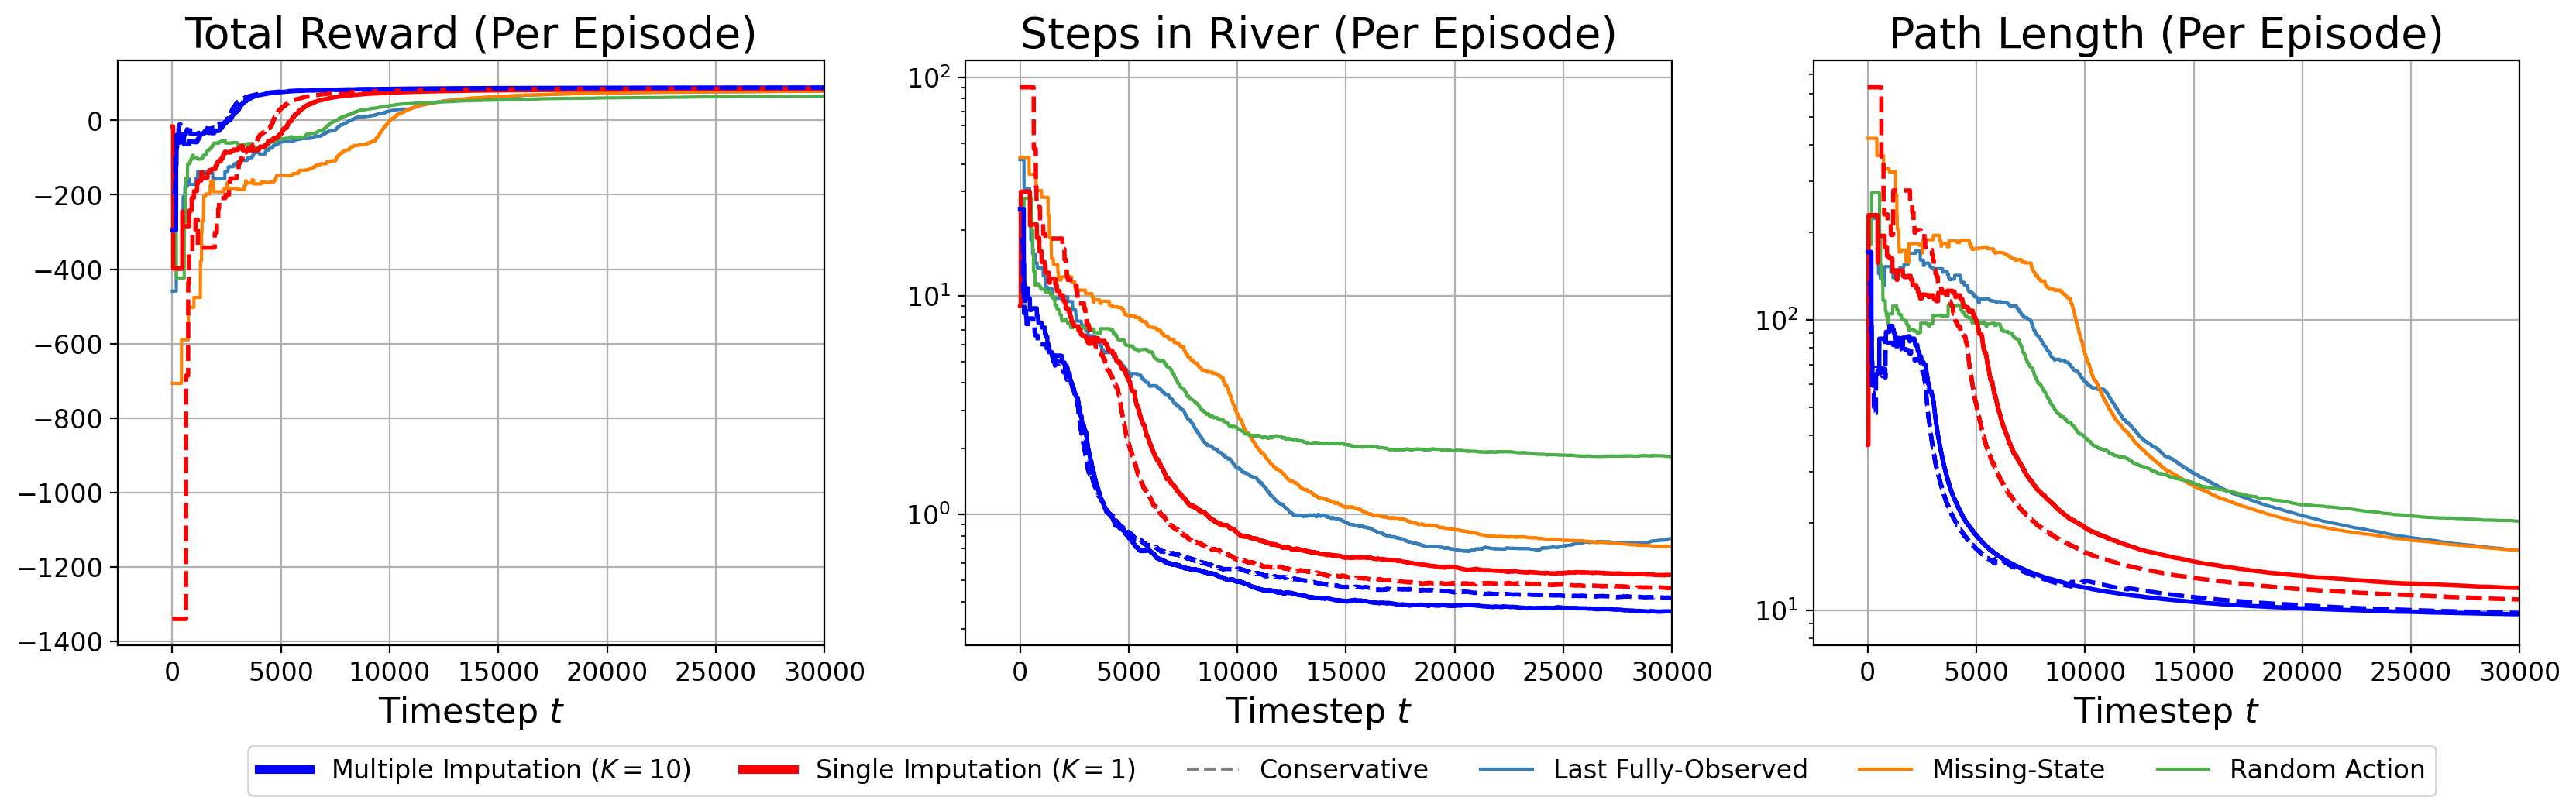

In [176]:
# create our subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5), sharex=True)

# cutoff for iterations 
CUTOFF = 30000

# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Total Reward (Per Episode)", "Steps in River (Per Episode)", "Path Length (Per Episode)"][i], fontsize=20)
    ax[i].set_xlabel("Timestep $t$", fontsize=16)
    
    #### BASELINES
    
    # plot last-fobs performance
    if i == 0:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].plot(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].plot(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].plot(ra_vals, color=colors[2])
        
    else:
        lf_vals = np.cumsum(lf[var].values) / (np.arange(len(lf[var].values)) + 1)
        lf_vals = sum([ [lf_vals[j]] * int(lf.path_length.values[j]) for j in range(len(lf.index))], [])
        ax[i].semilogy(lf_vals, color=colors[0])

        # plot missing-state performance
        ms_vals = np.cumsum(ms[var].values) / (np.arange(len(ms[var].values)) + 1)
        ms_vals = sum([ [ms_vals[j]] * int(ms.path_length.values[j]) for j in range(len(ms.index))], [])
        ax[i].semilogy(ms_vals, color=colors[1])

        # plot random-action performance
        ra_vals = np.cumsum(ra[var].values) / (np.arange(len(ra[var].values)) + 1)
        ra_vals = sum([ [ra_vals[j]] * int(ra.path_length.values[j]) for j in range(len(ra.index))], [])
        ax[i].semilogy(ra_vals, color=colors[2])
    
    #### OUR METHODS
    
    if i == 0:
    
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].plot(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].plot(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].plot(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].plot(jc10_vals, color="blue", linestyle="--", linewidth=2)
        
    else:
        
        # plot joint-1 (single imputation)
        j1_vals = np.cumsum(j1[var].values) / (np.arange(len(j1[var].values)) + 1)
        j1_vals = sum([ [j1_vals[j]] * int(j1.path_length.values[j]) for j in range(len(j1.index))], [])
        ax[i].semilogy(j1_vals, color="red", linewidth=2)

        # plot joint-10 (multiple imputation)
        j10_vals = np.cumsum(j10[var].values) / (np.arange(len(j10[var].values)) + 1)
        j10_vals = sum([ [j10_vals[j]] * int(j10.path_length.values[j]) for j in range(len(j10.index))], [])
        ax[i].semilogy(j10_vals, color="blue", linewidth=2)

       # plot joint-conservative-1 (single imputation)
        jc1_vals = np.cumsum(jc1[var].values) / (np.arange(len(jc1[var].values)) + 1)
        jc1_vals = sum([ [jc1_vals[j]] * int(jc1.path_length.values[j]) for j in range(len(jc1.index))], [])
        ax[i].semilogy(jc1_vals, color="red", linestyle="--", linewidth=2)

        # plot joint-conservative-10 (multiple imputation)
        jc10_vals = np.cumsum(jc10[var].values) / (np.arange(len(jc10[var].values)) + 1)
        jc10_vals = sum([ [jc10_vals[j]] * int(jc10.path_length.values[j]) for j in range(len(jc10.index))], [])
        ax[i].semilogy(jc10_vals, color="blue", linestyle="--", linewidth=2)
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Multiple Imputation ($K=10$)")
        ax[i].plot([np.nan], [np.nan], color="red", linewidth=4, label="Single Imputation ($K=1$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", label="Conservative")
        ax[i].plot([np.nan], [np.nan], color=colors[0], label="Last Fully-Observed")
        ax[i].plot([np.nan], [np.nan], color=colors[1], label="Missing-State")
        ax[i].plot([np.nan], [np.nan], color=colors[2], label="Random Action")
        ax[i].legend(ncol=6, fontsize=12, bbox_to_anchor=(+0.9, -0.15))
        ax[i].set_xlim(right=CUTOFF)
        
# save the figure
plt.savefig("figures/Mfog+t-in=0.25+t-out=0.1_perf-over-time.png", facecolor="white", bbox_inches="tight")
plt.show()

# Looking Within Multiple-Imputation Variants

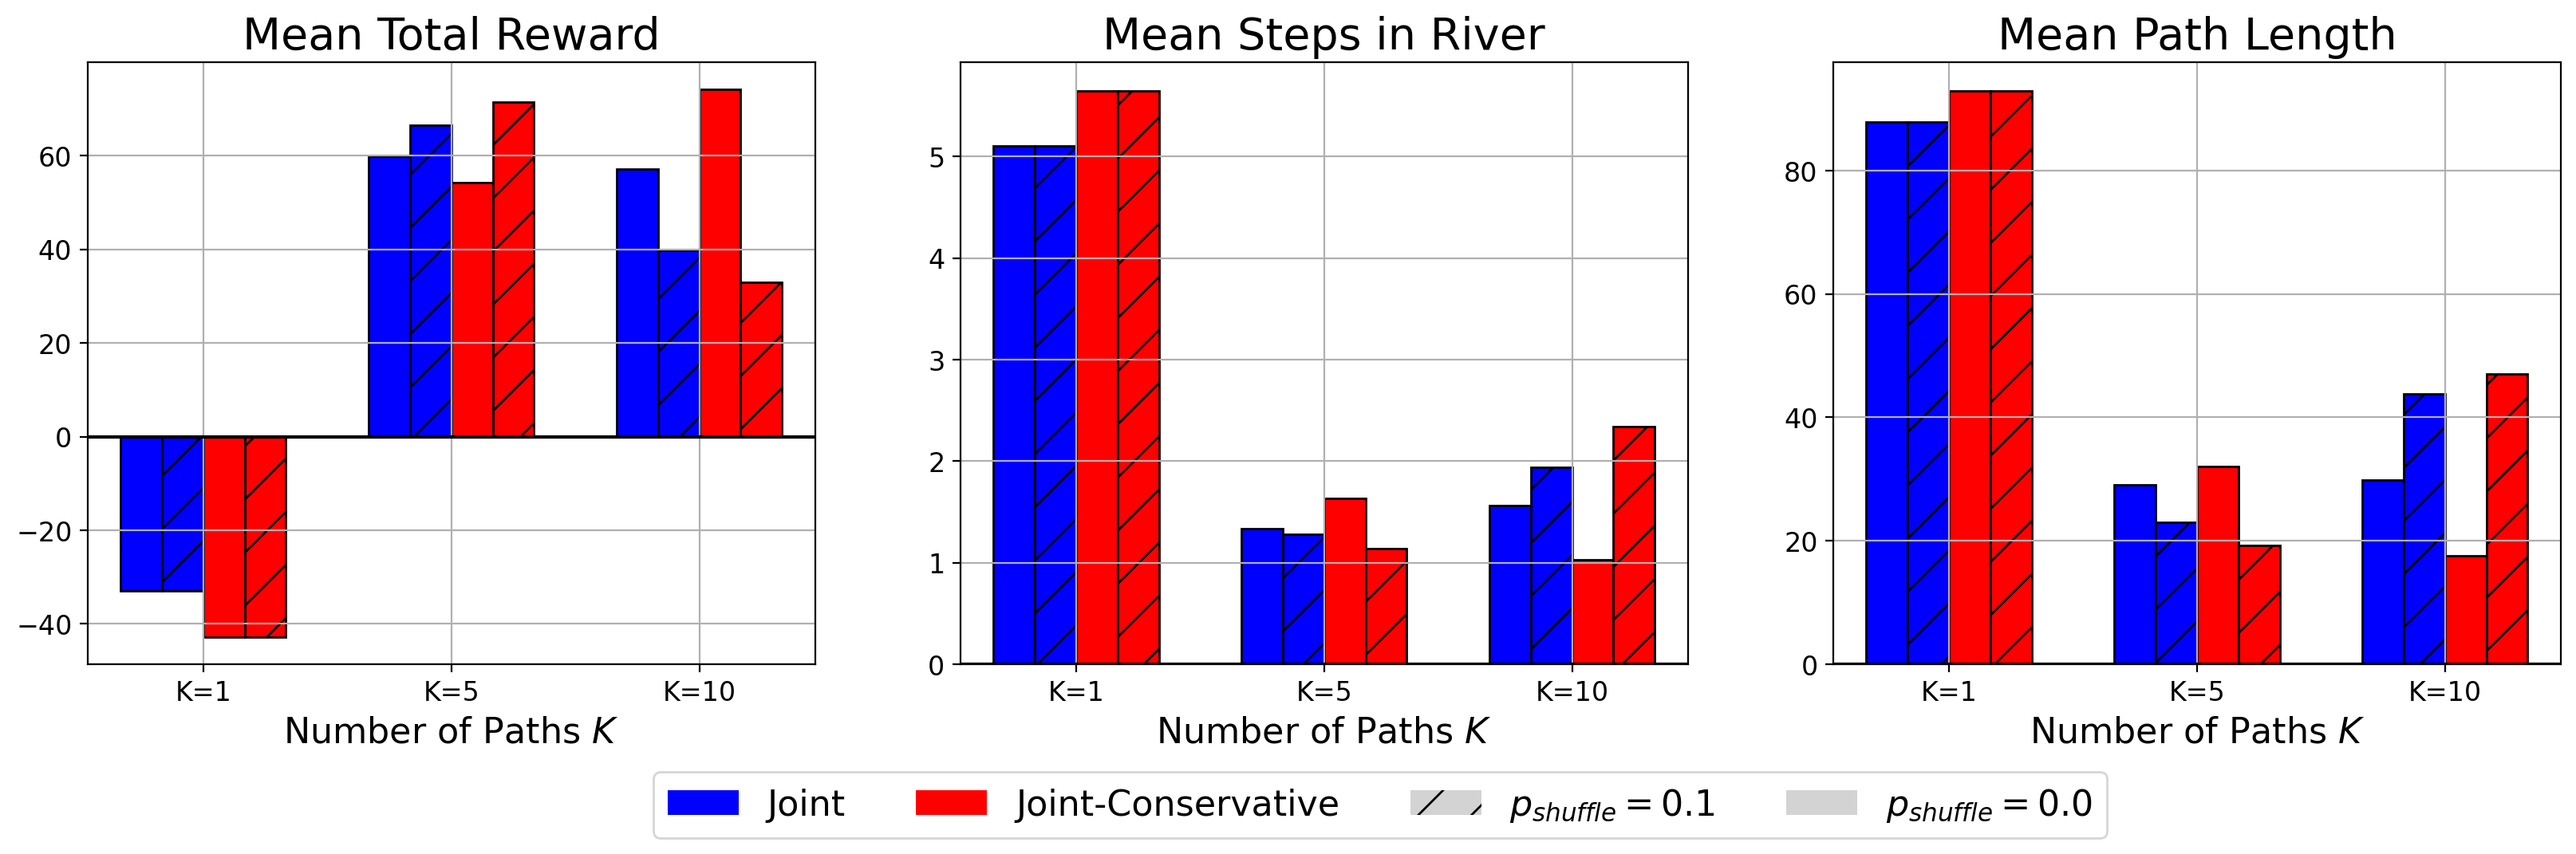

In [273]:
# hyperparameters to fix based on previous runs
head = "PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4"
tail = "max-iters=50000_eps=0.05_a=0.1_g=1.0"

# CUTOFF ON PERFORMANCE -- WE ALSO WANT TO LOOK AT CONVERGENCE
CUTOFF = 10000

# aesthetic purposes 
bar_width = 0.5

# separate bars for joint vs. joint conservative, p-shuffle vs. no p-shuffle
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5))

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # iterate through our K values
    for loc_idx, K in enumerate([1, 5, 10]):
        
        # create a counter for which bar
        bar_idx = 0
        
        for IM in ["joint", "joint-conservative"]:
            for p_shuf in [0.0, 0.1]:
                
                # what's our corresponding file?
                fname = f"{head}_IM={IM}_NC=1_K={K}_p-shuf={p_shuf}_{tail}"
                
                # create a list to store our results for all three seeds
                seed_vals = []
                
                # go thru each of our seeds
                for seed in range(3):
                    
                    # load the .csv file + look at the mean path length per episode until CUTOFF steps
                    df = pd.read_csv(f"results/{fname}/seed={seed}.csv")
                    seed_vals.append(df.loc[:np.argwhere(df.path_length.cumsum().values > CUTOFF)\
                                            [0,0]][var].mean())
                
                # create our bar chart 
                color = "blue" if IM == "joint" else "red"
                hatch = "/" if p_shuf == 0.1 else None
                ax[i].bar(x=(3*loc_idx)+([-1.5, -0.5, 0.5, 1.5][bar_idx])*bar_width, 
                          height=np.mean(seed_vals), width=bar_width, 
                          color=color, edgecolor="black", hatch=hatch)
                
                # increment our bar_idx
                bar_idx += 1
                
    # beautify a little bit
    ax[i].set_xticks([0.0, 3.0, 6.0])
    ax[i].set_xticklabels(["K=1", "K=5", "K=10"], fontsize=14)
    
    # beautify a little bit
    ax[i].axhline(y=0.0, color="black")
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Mean Total Reward", "Mean Steps in River", "Mean Path Length"][i], fontsize=20)
    ax[i].set_xlabel("Number of Paths $K$", fontsize=16)
    
    # make a legend if it's the last one
    if i == 2:
        ax[i].bar(x=np.nan, height=np.nan, color="blue", label="Joint")
        ax[i].bar(x=np.nan, height=np.nan, color="red", label="Joint-Conservative")
        ax[i].bar(x=np.nan, height=np.nan, color="lightgrey", hatch="/", label="$p_{shuffle} = 0.1$")
        ax[i].bar(x=np.nan, height=np.nan, color="lightgrey", hatch=None, label="$p_{shuffle} = 0.0$")
        ax[i].legend(ncol=4, fontsize=16, bbox_to_anchor=(+0.4, -0.15))
        
# save our figure
plt.savefig("figures/MI-params_MCAR+theta=0.4_eps=0.05_a=0.1_g=1.0_ASA=False_MAX=10K.png", 
            bbox_inches="tight", facecolor="white")
plt.show()

# Looking at MCAR + Effect of $ASA$ over multiple $\theta$ values.

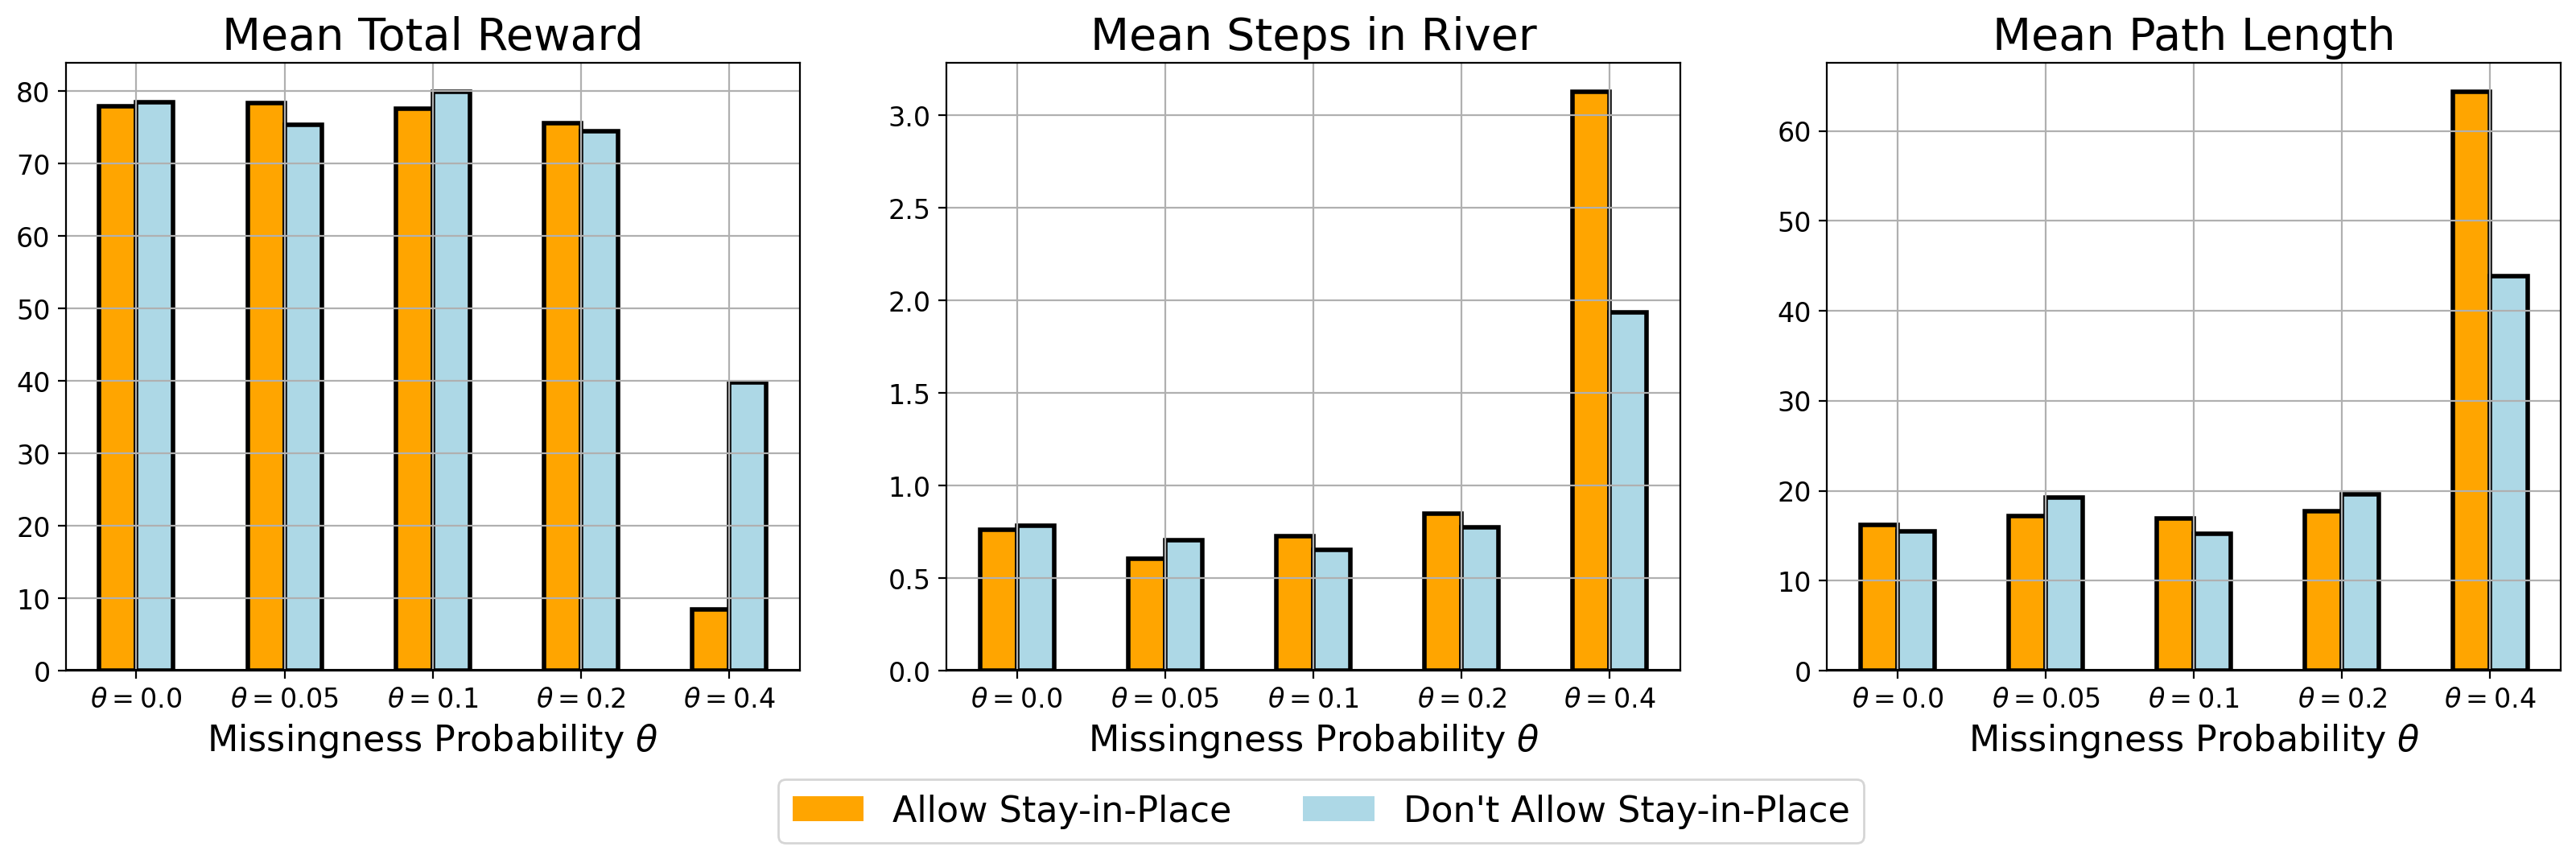

In [300]:
# CUTOFF ON PERFORMANCE -- WE ALSO WANT TO LOOK AT CONVERGENCE
CUTOFF = 10000

# aesthetic purposes 
bar_width = 0.5
t = "t"

# separate bars for joint vs. joint conservative, p-shuffle vs. no p-shuffle
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5))

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # iterate through our K values
    for loc_idx, theta in enumerate([0.0, 0.05, 0.1, 0.2, 0.4]):
        
        # look at ASA = T vs. ASA = F
        for bar_idx, ASA in enumerate(["T", "F"]):
                
            # what's our corresponding file?
            fname = f"PS=0.1_PW=0.1_MM=MCAR_ASA={ASA}_theta={theta}_IM=joint_NC=1_K=10_p-shuf=0.1_max-iters=50000_eps=0.05_a=0.1_g=1.0"

            # create a list to store our results for all three seeds
            seed_vals = []

            # go thru each of our seeds
            for seed in range(3):

                # load the .csv file + look at the mean path length per episode until CUTOFF steps
                df = pd.read_csv(f"results/{fname}/seed={seed}.csv")
                seed_vals.append(df.loc[:np.argwhere(df.path_length.cumsum().values > CUTOFF)\
                                        [0,0]][var].mean())

            # create our bar chart 
            color = "orange" if ASA == "T" else "lightblue"
            ax[i].bar(x=(2*loc_idx)+([-0.5, 0.5][bar_idx])*bar_width, 
                      height=np.mean(seed_vals), width=bar_width, 
                      color=color, edgecolor="black", linewidth=2)
                
    # beautify a little bit
    ax[i].set_xticks([0, 2, 4, 6, 8])
    ax[i].set_xticklabels([f"$\{t}heta=0.0$", f"$\{t}heta=0.05$", f"$\{t}heta=0.1$", 
                           f"$\{t}heta=0.2$", f"$\{t}heta=0.4$"], fontsize=14)
    
    # beautify a little bit
    ax[i].axhline(y=0.0, color="black")
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Mean Total Reward", "Mean Steps in River", "Mean Path Length"][i], fontsize=20)
    ax[i].set_xlabel(f"Missingness Probability $\{t}heta$", fontsize=16)
    
    # make a legend if it's the last one
    if i == 2:
        ax[i].bar(x=np.nan, height=np.nan, color="orange", label="Allow Stay-in-Place")
        ax[i].bar(x=np.nan, height=np.nan, color="lightblue", label="Don't Allow Stay-in-Place")
        ax[i].legend(ncol=4, fontsize=16, bbox_to_anchor=(+0.075, -0.15))
        
# save our figure
plt.savefig("figures/ASA-analysis+MI=joint+K=10_MCAR+theta=0.4_eps=0.05_a=0.1_g=1.0_MAX=10K.png", 
            bbox_inches="tight", facecolor="white")
plt.show()

# Timeseries Plot of ASA = True vs. ASA = False

In [318]:
# what's our corresponding file?
tail = "IM=joint_NC=1_K=10_p-shuf=0.1_max-iters=50000_eps=0.0_a=0.1_g=1.0"
ASAT = pd.read_csv(f"results/PS=0.1_PW=0.1_MM=MCAR_ASA=T_theta=0.4_{tail}/seed=0.csv")
ASAF = pd.read_csv(f"results/PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_{tail}/seed=0.csv")

tail_eps = "IM=joint_NC=1_K=10_p-shuf=0.1_max-iters=50000_eps=0.05_a=0.1_g=1.0"
ASAT_eps = pd.read_csv(f"results/PS=0.1_PW=0.1_MM=MCAR_ASA=T_theta=0.4_{tail_eps}/seed=0.csv")
ASAF_eps = pd.read_csv(f"results/PS=0.1_PW=0.1_MM=MCAR_ASA=F_theta=0.4_{tail_eps}/seed=0.csv")

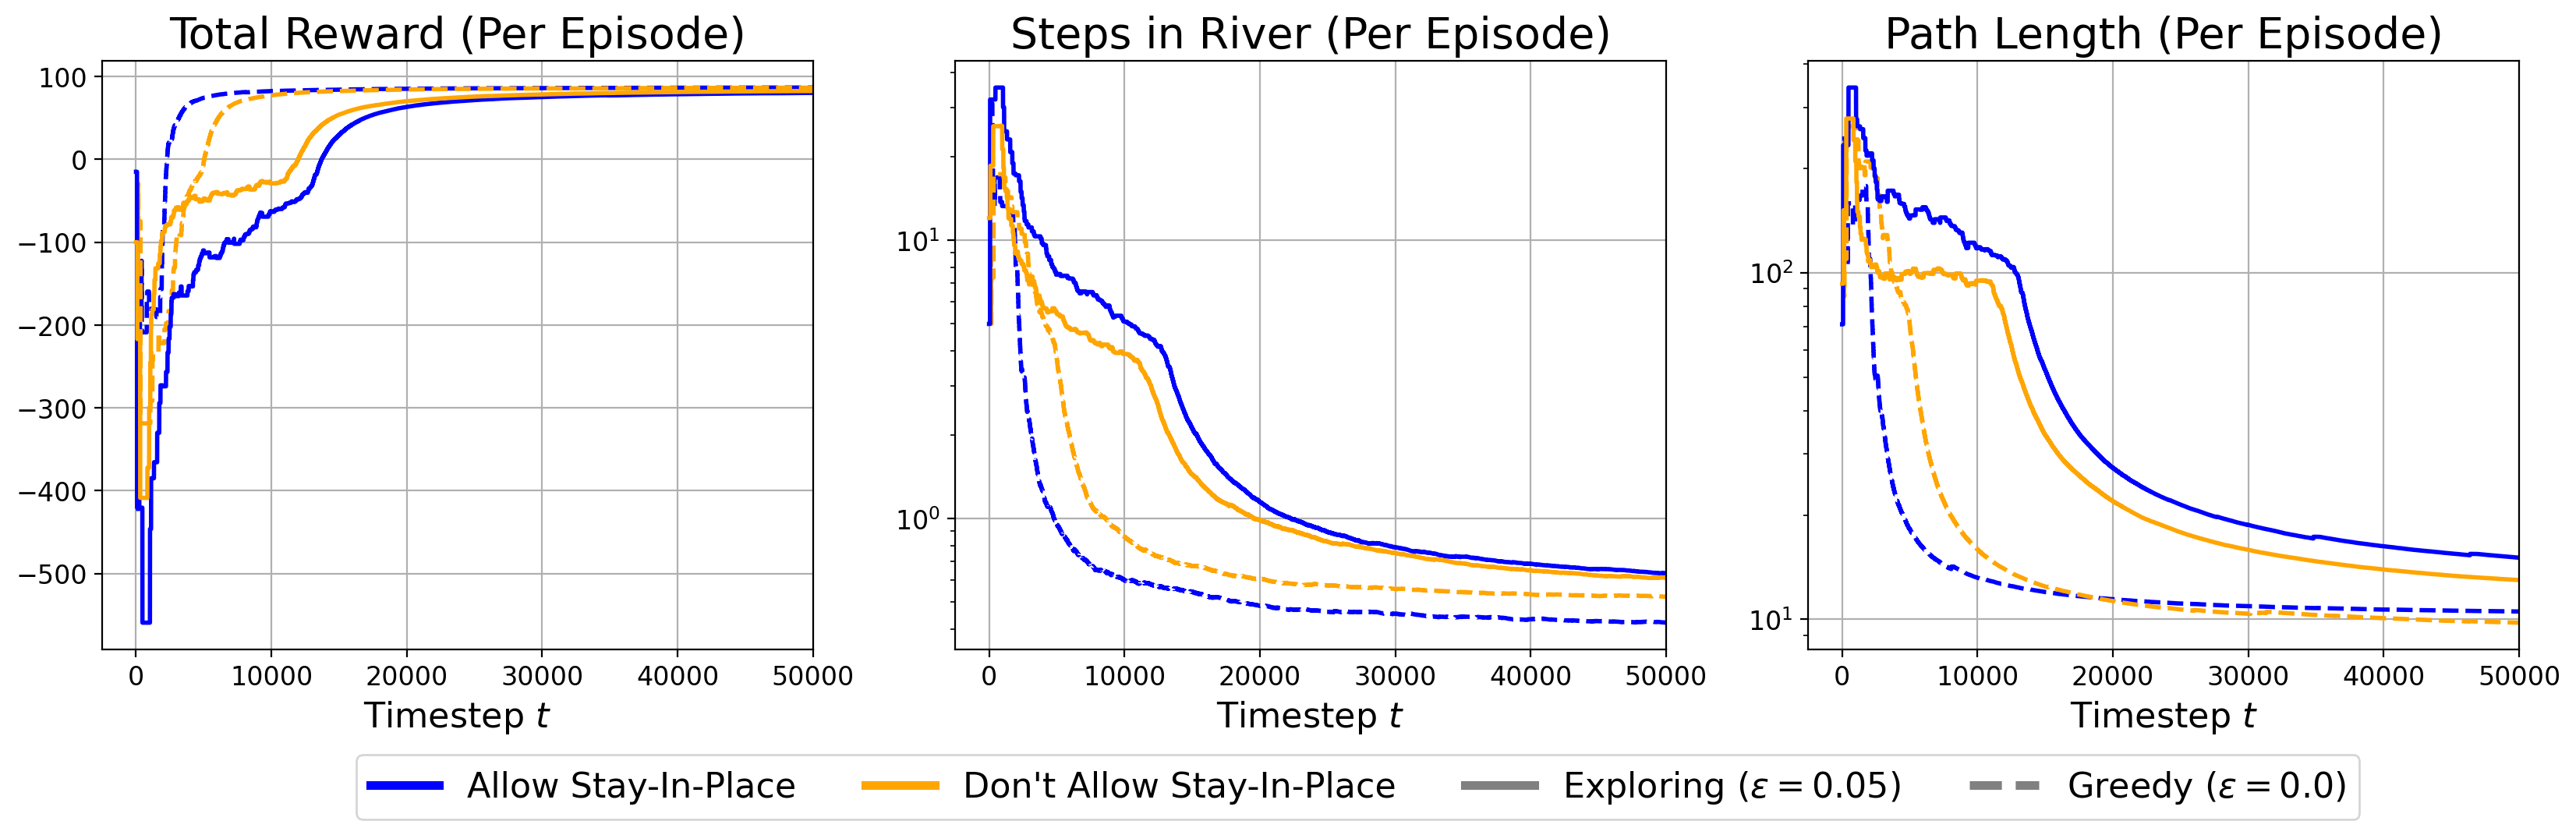

In [326]:
# create our subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 5), sharex=True)

# cutoff for iterations 
CUTOFF = 50000

# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# plot each of our metrics of interest
for i, var in enumerate(["total_reward", "steps_river", "path_length"]):
    
    # beautify a little bit
    ax[i].grid()
    ax[i].tick_params("both", labelsize=12)
    ax[i].set_title(["Total Reward (Per Episode)", "Steps in River (Per Episode)", "Path Length (Per Episode)"][i], fontsize=20)
    ax[i].set_xlabel("Timestep $t$", fontsize=16)
    
    #### OUR METHODS
    
    if i == 0:
    
        # plot ASA=True EPS=0.0 variant
        ASAT_vals = np.cumsum(ASAT[var].values) / (np.arange(len(ASAT[var].values)) + 1)
        ASAT_vals = sum([ [ASAT_vals[j]] * int(ASAT.path_length.values[j]) for j in range(len(ASAT.index))], [])
        ax[i].plot(ASAT_vals, color="blue", linewidth=2, linestyle="--")
        
        # plot ASA=False EPS=0.0 variant
        ASAF_vals = np.cumsum(ASAF[var].values) / (np.arange(len(ASAF[var].values)) + 1)
        ASAF_vals = sum([ [ASAF_vals[j]] * int(ASAF.path_length.values[j]) for j in range(len(ASAF.index))], [])
        ax[i].plot(ASAF_vals, color="orange", linewidth=2, linestyle="--")
        
        # plot ASA=True EPS=0.05 variant
        ASAT_eps_vals = np.cumsum(ASAT_eps[var].values) / (np.arange(len(ASAT_eps[var].values)) + 1)
        ASAT_eps_vals = sum([ [ASAT_eps_vals[j]] * int(ASAT_eps.path_length.values[j]) for j in range(len(ASAT_eps.index))], [])
        ax[i].plot(ASAT_eps_vals, color="blue", linewidth=2)
        
        # plot ASA=False EPS=0.05 variant
        ASAF_eps_vals = np.cumsum(ASAF_eps[var].values) / (np.arange(len(ASAF_eps[var].values)) + 1)
        ASAF_eps_vals = sum([ [ASAF_eps_vals[j]] * int(ASAF_eps.path_length.values[j]) for j in range(len(ASAF_eps.index))], [])
        ax[i].plot(ASAF_eps_vals, color="orange", linewidth=2)
        
    else:
        
        # plot ASA=True EPS=0.0 variant
        ASAT_vals = np.cumsum(ASAT[var].values) / (np.arange(len(ASAT[var].values)) + 1)
        ASAT_vals = sum([ [ASAT_vals[j]] * int(ASAT.path_length.values[j]) for j in range(len(ASAT.index))], [])
        ax[i].semilogy(ASAT_vals, color="blue", linewidth=2, linestyle="--")
        
        # plot ASA=False EPS=0.0 variant
        ASAF_vals = np.cumsum(ASAF[var].values) / (np.arange(len(ASAF[var].values)) + 1)
        ASAF_vals = sum([ [ASAF_vals[j]] * int(ASAF.path_length.values[j]) for j in range(len(ASAF.index))], [])
        ax[i].semilogy(ASAF_vals, color="orange", linewidth=2, linestyle="--")
        
        # plot ASA=True EPS=0.05 variant
        ASAT_eps_vals = np.cumsum(ASAT_eps[var].values) / (np.arange(len(ASAT_eps[var].values)) + 1)
        ASAT_eps_vals = sum([ [ASAT_eps_vals[j]] * int(ASAT_eps.path_length.values[j]) for j in range(len(ASAT_eps.index))], [])
        ax[i].semilogy(ASAT_eps_vals, color="blue", linewidth=2)
        
        # plot ASA=False EPS=0.05 variant
        ASAF_eps_vals = np.cumsum(ASAF_eps[var].values) / (np.arange(len(ASAF_eps[var].values)) + 1)
        ASAF_eps_vals = sum([ [ASAF_eps_vals[j]] * int(ASAF_eps.path_length.values[j]) for j in range(len(ASAF_eps.index))], [])
        ax[i].semilogy(ASAF_eps_vals, color="orange", linewidth=2)
    
    # create a legend only for the last subplot
    if i == 2:
        ax[i].plot([np.nan], [np.nan], color="blue", linewidth=4, label="Allow Stay-In-Place")
        ax[i].plot([np.nan], [np.nan], color="orange", linewidth=4, label="Don't Allow Stay-In-Place")
        ax[i].plot([np.nan], [np.nan], color="grey", linewidth=4, label="Exploring ($\epsilon = 0.05$)")
        ax[i].plot([np.nan], [np.nan], color="grey", linestyle="--", linewidth=4, label="Greedy ($\epsilon = 0.0$)")
        ax[i].legend(ncol=6, fontsize=16, bbox_to_anchor=(+0.8, -0.15))
        ax[i].set_xlim(right=CUTOFF)
        
# save the figure
plt.savefig("figures/MCAR+theta=0.4_K=10_ASA=T-v-F_eps=0.05-v-0.0_p-shuf=0.1_g=1.0_a=0.1.png", facecolor="white", bbox_inches="tight")
plt.show()

# Deprecated

In [ ]:
# 2. visualize Q function on MCAR + theta=0.4: best joint vs. best baseline (looks like shit) (2x2)
# 2 models, 2 {flood vs. no flood.}

# 5. MI details -- look at K=1, K=5, K=10 and p-shuffle = 0.1 vs. 0.0
# MCAR at theta=0.4, max_wind and max_switch. x-axis: K=1,5,10, 1 line for p-shuffle 1 line for no-shuffle
# lets do a 1x3 for each metric of {reward, river_steps, path_length}

# 6. Less beautiful-looking things -- Mcolor and Mfog (PS and PW are maxed out.). 2x2
# x-axis: timestep (step function), y-axis: path_length, 
# 3 baselines + K={1, 10} x {joint, joint-cons} x {best shuffle}

# 7. ablation study of joint vs. joint-conservative

In [ ]:
# PS: 0 vs. 0.1, PW: 0 vs. 0.1
# MCAR + {0.0, 0.05, 0.1, 0.2, 0.4}, Mfog + {2 variants}, Mcolor + {2 variants}
# gamma: {1.0, 0.5, 0.0}, alpha: {1.0, SW boobooed}, epsilon: {0.0, 0.05} -- just take whatever performed best.